# Post processing for the generation 2023 and 2030

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

BASE_DIR = Path.cwd() 

In [3]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 16
})


In [4]:
# Master fuel-type mapping dictionary
fuel_mapping = {
    # Your provided coded types
    "WND": "Wind",
    "SUN": "Solar",
    "NG": "Natural Gas",
    "DFO": "Distillate Fuel Oil",
    "LFG": "Landfill Gas",
    "MWH": "Energy Storage",
    "OBG": "Biomass",
    "WAT": "Hydro",
    "NUC": "Nuclear Fuel",
    "OTH": "Other",

    # Additional common EIA categories
    "BIT": "Bituminous",
    "SUB": "Subbituminous",
    "RFO": "Residual Fuel Oil",
    "WDS": "Wood/Waste Biomass",
    "PC": "Petroleum Coke",
    "WC": "Waste Coal",
    "RC": "Refined Coal",
    "JF": "Jet Fuel",
    "BLQ": "Black Liquor",
    "BFG": "Blast Furnace Gas",
    "WH": "Waste Heat",
    "OG": "Other Gas",
    "OBL": "Other Biomass Liquid",
    "OBS": "Other Biomass Solid",
    "PUR": "Purchased Steam",
    "AB": "Agricultural Byproducts",
}

# For multi-value categories:
multi_fuel_replacements = {
    "Natural Gas, Distillate Fuel Oil": "Natural Gas",
    "Natural Gas, Residual Fuel Oil": "Natural Gas",
    "Natural Gas, Distillate Fuel Oil, Hydrogen": "Natural Gas",
    "Bituminous, Waste Coal": "Bituminous",
    "Bituminous, Subbituminous": "Bituminous",
}
def normalize_fuel_type(ft):
    if pd.isna(ft):
        return "Other"

    ft = str(ft).strip()

    # Direct match for multi-fuel categories
    if ft in multi_fuel_replacements:
        return multi_fuel_replacements[ft]

    # If exact match in mapping
    if ft in fuel_mapping:
        return fuel_mapping[ft]

    # If it's already a clean long-form type (Wind, Solar, Biomass, etc.)
    if ft in [
        "Wind", "Solar", "Biomass", "Hydro", "Nuclear Fuel", "Energy Storage",
        "Natural Gas", "Bituminous", "Subbituminous", "Petroleum Coke",
        "Landfill Gas", "Waste Coal", "MSW", "Pumped Storage"
    ]:
        return ft

    # Not found → return category as-is or map to "Other"
    return ft


In [7]:

# --------------------------------------------------
# Load generation dataset
# --------------------------------------------------


df_2023 = pd.read_csv(BASE_DIR / "data/inputs/Base_Case/matpower_generators_combined.csv")  

df_2030 = pd.read_csv(BASE_DIR / "data/inputs/Planned_Case/combined_generation.csv")

df_2023["YEAR"] = 2023
df_2030["YEAR"] = 2030


df_2023["Fuel_Normalized"] = df_2023["FUEL_TYPE"].apply(normalize_fuel_type)
df_2030["Fuel_Normalized"] = df_2030["FUEL_TYPE"].apply(normalize_fuel_type)
df_all = pd.concat([df_2023, df_2030], ignore_index=True)


<Figure size 1200x700 with 0 Axes>

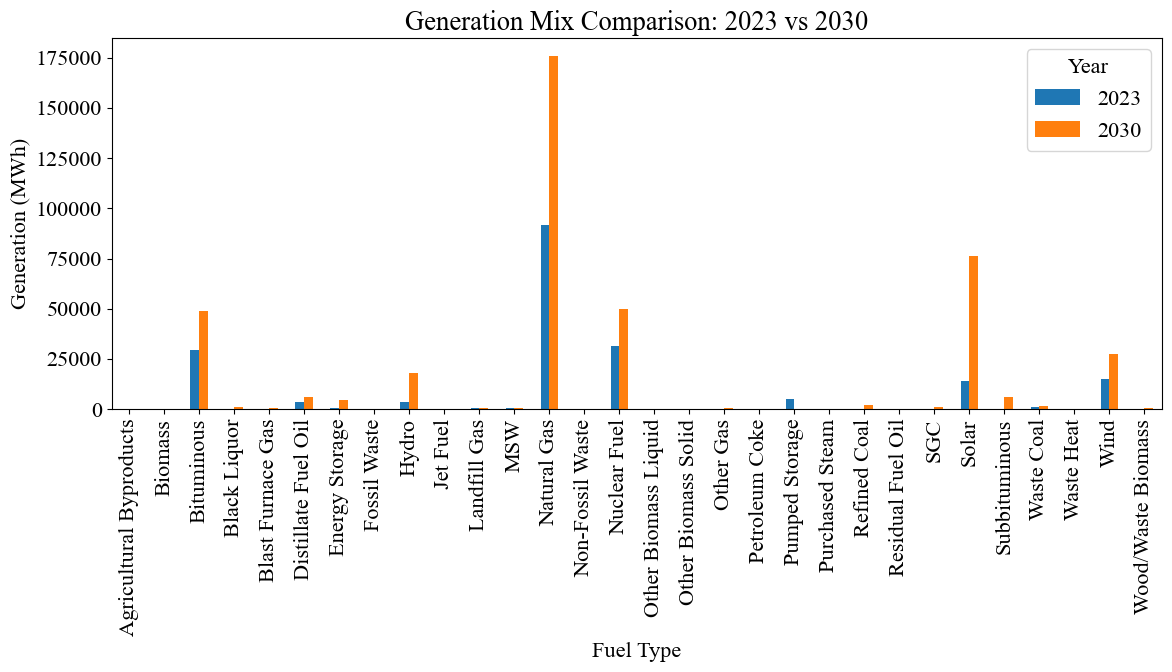

In [8]:
# Aggregate by fuel type
gen_mix = df_all.groupby(['YEAR', 'Fuel_Normalized'])['PMAX'].sum().reset_index()

# Pivot for bar chart
gen_pivot = gen_mix.pivot(index='Fuel_Normalized', columns='YEAR', values='PMAX').fillna(0)
gen_pivot

plt.figure(figsize=(12, 7))

gen_pivot.plot(kind='bar', figsize=(12, 7))

plt.title("Generation Mix Comparison: 2023 vs 2030")
plt.ylabel("Generation (MWh)")
plt.xlabel("Fuel Type")
plt.xticks(rotation=90)
plt.legend(title="Year")
plt.tight_layout()
plt.show()


In [9]:
broad_category_map = {
    # Clear categories
    "Wind": "Wind",
    "Solar": "Solar",
    "Energy Storage": "Storage",
    "Natural Gas": "Natural Gas",

    # Coal categories
    "Bituminous": "Coal",
    "Subbituminous": "Coal",
    "Refined Coal": "Coal",
    "Petroleum Coke": "Coal",
    "Waste Coal": "Coal",

    # Nuclear
    "Nuclear Fuel": "Nuclear",

    # Hydro
    "Hydro": "Hydro",

    # Biomass-related
    "Biomass": "Biomass",
    "Wood/Waste Biomass": "Biomass",
    "Other Biomass Liquid": "Biomass",
    "Other Biomass Solid": "Biomass",
    "Agricultural Byproducts": "Biomass",
    "Black Liquor": "Biomass",

    # Everything else
    "Distillate Fuel Oil": "Other",
    "Residual Fuel Oil": "Other",
    "Landfill Gas": "Other",
    "Other Gas": "Other",
    "Blast Furnace Gas": "Other",
    "Waste Heat": "Other",
    "Purchased Steam": "Other",
    "Other": "Other",
}


gen_mix['Category'] = gen_mix['Fuel_Normalized'].map(broad_category_map).fillna("Other")


In [10]:
gen_pivot = (
    gen_mix
    .groupby(['Category', 'YEAR'])['PMAX']
    .sum()
    .reset_index()
    .pivot(index='Category', columns='YEAR', values='PMAX')
    .fillna(0)
)


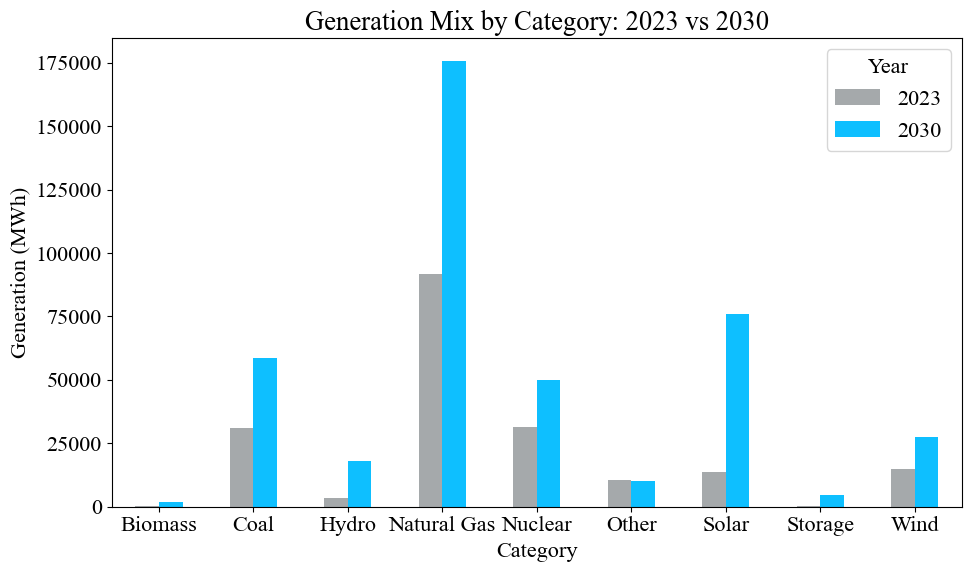

In [11]:
year_colors = {
    2023: "#a5a9ab",  # grey for base
    2030: "#0ebfff",  # blue for policy
}

# Plot
gen_pivot.plot(
    kind="bar",
    figsize=(10, 6),
    color=[year_colors[year] for year in gen_pivot.columns]
)

plt.title("Generation Mix by Category: 2023 vs 2030")
plt.ylabel("Generation (MWh)")
plt.xlabel("Category")
plt.xticks(rotation=0)
plt.legend(title="Year")
plt.tight_layout()
plt.show()


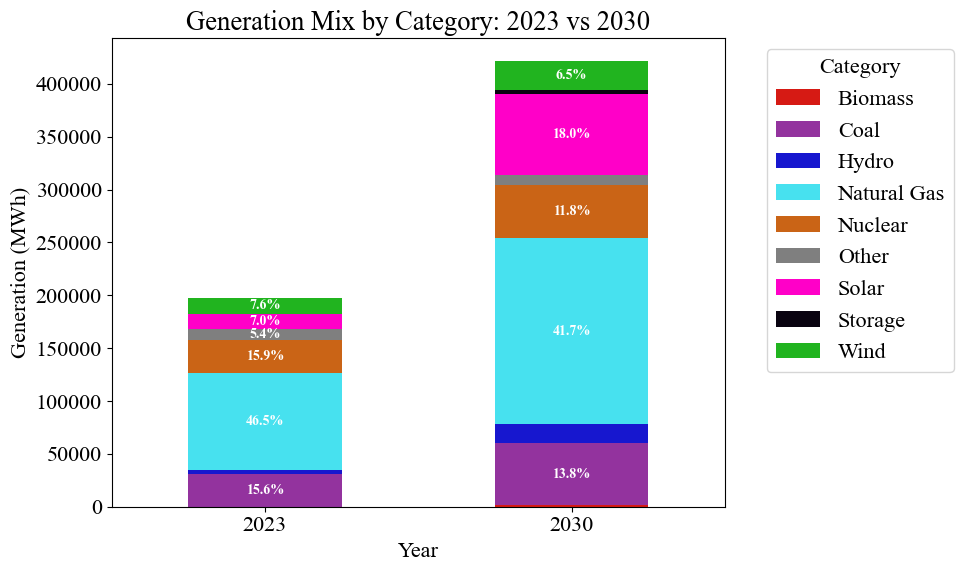

In [12]:


# Define colors for categories
colors = {
    "Wind": "#21b41f",
    "Solar": "#ff00c8",
    "Storage": "#090310",
    "Coal": "#93339e",
    "Natural Gas": "#47e1ef",
    "Nuclear": "#ca6416",
    "Hydro": "#1717cf",
    "Biomass": "#d61a14",
    "Other": "#7f7f7f",
}

# Transpose for plotting years on x-axis
gen_plot = gen_pivot.T  # now rows = years, columns = categories

# Plot stacked bars
ax = gen_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=[colors[c] for c in gen_plot.columns]
)

# Add percentages on top of each segment
for i, year in enumerate(gen_plot.index):
    total = gen_plot.loc[year].sum()
    cum_height = 0
    for category in gen_plot.columns:
        val = gen_plot.loc[year, category]
        if val > 0:
            percent = val / total * 100
            if percent >= 5:  # only print if ≥5%
                ax.text(
                    i,                        # x position
                    cum_height + val / 2,     # y position in the middle of the segment
                    f"{percent:.1f}%",        # text
                    ha='center',
                    va='center',
                    fontsize=10,
                    color='white',
                    fontweight='bold'
                )
        cum_height += val

# Labels and legend
plt.ylabel("Generation (MWh)")
plt.xlabel("Year")
plt.title("Generation Mix by Category: 2023 vs 2030")
plt.xticks(rotation=0)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
# Compute absolute change
change_abs = gen_pivot[2030] - gen_pivot[2023]

# Compute percentage change
change_pct = (change_abs / gen_pivot[2023]) * 100

# Build final comparison table
gen_change_table = pd.DataFrame({
    "2023 Generation": gen_pivot[2023],
    "2030 Generation": gen_pivot[2030],
    "Absolute Change": change_abs,
    "Percent Change (%)": change_pct.round(1),
})

gen_change_table


2023 Generation  2030 Generation  Absolute Change  \
Category                                                         
Biomass                136.9           1687.5           1550.6   
Coal                 30874.9          58448.8          27573.9   
Hydro                 3357.5          18029.8          14672.3   
Natural Gas          91850.0         175859.5          84009.5   
Nuclear              31414.1          49940.9          18526.8   
Other                10576.8           9992.9           -583.9   
Solar                13793.6          76153.2          62359.6   
Storage                449.9           4489.7           4039.8   
Wind                 15049.7          27469.1          12419.4   

             Percent Change (%)  
Category                         
Biomass                  1132.7  
Coal                       89.3  
Hydro                     437.0  
Natural Gas                91.5  
Nuclear                    59.0  
Other                      -5.5  
Solar                     452.1  
Storage                   897.9  
Wind                       82.5

# Transmission lines visuals

In [14]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

shp_path = BASE_DIR / "data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp"   # change this to your file
zones = gpd.read_file(shp_path)

network_path = BASE_DIR / "data/inputs/Base_Case/Network.csv"
network = gpd.read_file(network_path)
zones_keep = [
    'PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
    'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West'
]

# Inspect columns
print(zones.columns)
print(network.columns)

zones = zones[zones['IPM_Region'].isin(zones_keep)]

zones["centroid"] = zones.geometry.centroid



# Plot the lines with variable thickness
# Merge: from_zone → start_point
lines = network.merge(
    zones[["IPM_Region", "centroid"]],
    left_on="End_Zone",
    right_on="IPM_Region",
    how="left"
).rename(columns={"centroid": "start_point"}).drop(columns=["IPM_Region"])

# Merge: to_zone → end_point
lines = lines.merge(
    zones[["IPM_Region", "centroid"]],
    left_on="Start_Zone",
    right_on="IPM_Region",
    how="left"
).rename(columns={"centroid": "end_point"}).drop(columns=["IPM_Region"])


def make_line(row):
    return LineString([row["start_point"], row["end_point"]])

lines["geometry"] = lines.apply(make_line, axis=1)

network = gpd.GeoDataFrame(lines, geometry="geometry", crs=zones.crs)

min_width = 0.5
max_width = 8

network["Line_Max_Flow_MW"] = (
    pd.to_numeric(network["Line_Max_Flow_MW"], errors="coerce")
)

cap = network["Line_Max_Flow_MW"]
cap_norm = (cap - 1000) / (10000 - 1000)
network["line_width"] = min_width + cap_norm * (max_width - min_width)





Index(['IPM_Region', 'geometry'], dtype='object')
Index(['Zone_numbers', 'Network_zones', 'Network_Lines', 'Start_Zone',
       'End_Zone', 'Line_Max_Flow_MW', 'transmission_path_name',
       'distance_mile', 'Line_Loss_Percentage', 'Line_Max_Reinforcement_MW',
       'Line_Reinforcement_Cost_per_MWyr', 'DerateCapRes_1', 'CapRes_Excl_1'],
      dtype='object')


# Modified network visuals

In [15]:


shp_path = BASE_DIR / "data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp"   # change this to your file
zones = gpd.read_file(shp_path)

network_path = BASE_DIR / "data/inputs/Planned_Case/Network_modified.csv"
network = gpd.read_file(network_path)
zones_keep = [
    'PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
    'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West'
]

# Inspect columns
print(zones.columns)
print(network.columns)

zones = zones[zones['IPM_Region'].isin(zones_keep)]

zones["centroid"] = zones.geometry.centroid



# Plot the lines with variable thickness
# Merge: from_zone → start_point
lines = network.merge(
    zones[["IPM_Region", "centroid"]],
    left_on="End_Zone",
    right_on="IPM_Region",
    how="left"
).rename(columns={"centroid": "start_point"}).drop(columns=["IPM_Region"])

# Merge: to_zone → end_point
lines = lines.merge(
    zones[["IPM_Region", "centroid"]],
    left_on="Start_Zone",
    right_on="IPM_Region",
    how="left"
).rename(columns={"centroid": "end_point"}).drop(columns=["IPM_Region"])


def make_line(row):
    return LineString([row["start_point"], row["end_point"]])

lines["geometry"] = lines.apply(make_line, axis=1)

network = gpd.GeoDataFrame(lines, geometry="geometry", crs=zones.crs)

min_width = 0.5
max_width = 8

network["Line_Max_Flow_MW"] = (
    pd.to_numeric(network["Line_Max_Flow_MW"], errors="coerce")
)

cap = network["Line_Max_Flow_MW"]
cap_norm = (cap - 1000) / (10000 - 1000)

network["line_width"] = min_width + cap_norm * (max_width - min_width)





Index(['IPM_Region', 'geometry'], dtype='object')
Index(['field_1', 'Zone_numbers', 'Network_zones', 'Network_Lines',
       'Start_Zone', 'End_Zone', 'Line_Max_Flow_MW', 'transmission_path_name',
       'distance_mile', 'Line_Loss_Percentage', 'Line_Max_Reinforcement_MW',
       'Line_Reinforcement_Cost_per_MWyr', 'DerateCapRes_1', 'CapRes_Excl_1',
       'branch_idx'],
      dtype='object')


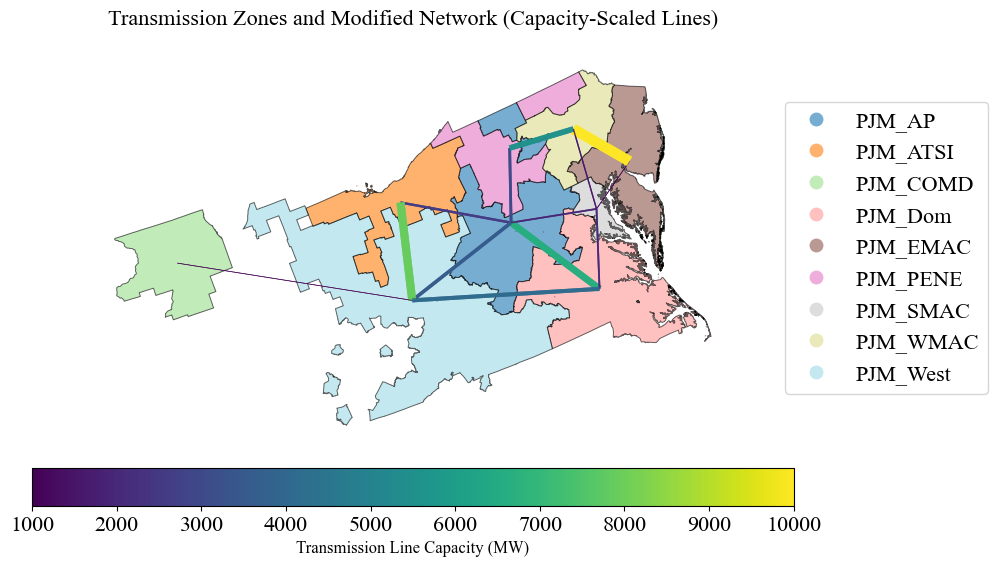

In [16]:


# ---------------------------------------------------------
# 7. PLOT EVERYTHING
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# ---- ZONES IN DISTINCT COLORS ----
zones.plot(
    ax=ax,
    column="IPM_Region",
    cmap="tab20",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1.05, 0.5)},
    edgecolor="black",
    linewidth=0.7,
    alpha=0.6
)

# ---- TRANSMISSION LINES ----
lines_plot = network.plot(
    ax=ax,
    column="Line_Max_Flow_MW",
    linewidth=network["line_width"],
    cmap="viridis",
    alpha=0.9
)

# ---- COLORBAR UNDER THE PLOT FOR CAPACITY ----
sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=mcolors.Normalize(vmin=1000, vmax=10000)
)
sm._A = []  # required trick
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Transmission Line Capacity (MW)", fontsize=12)

ax.set_title("Transmission Zones and Modified Network (Capacity-Scaled Lines)", fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

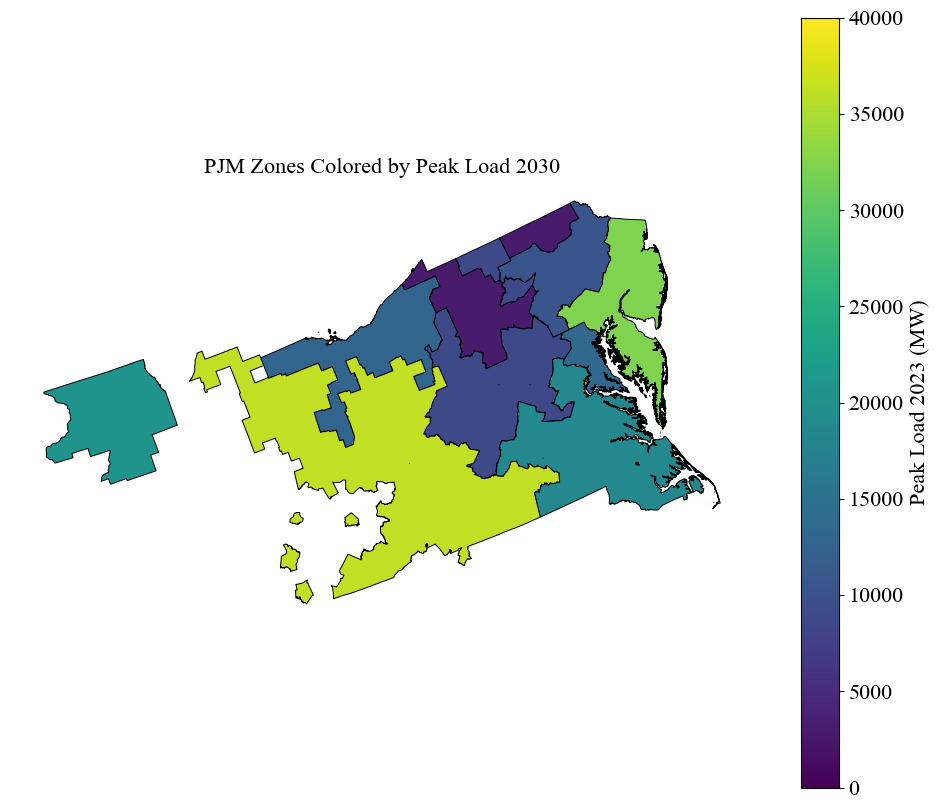

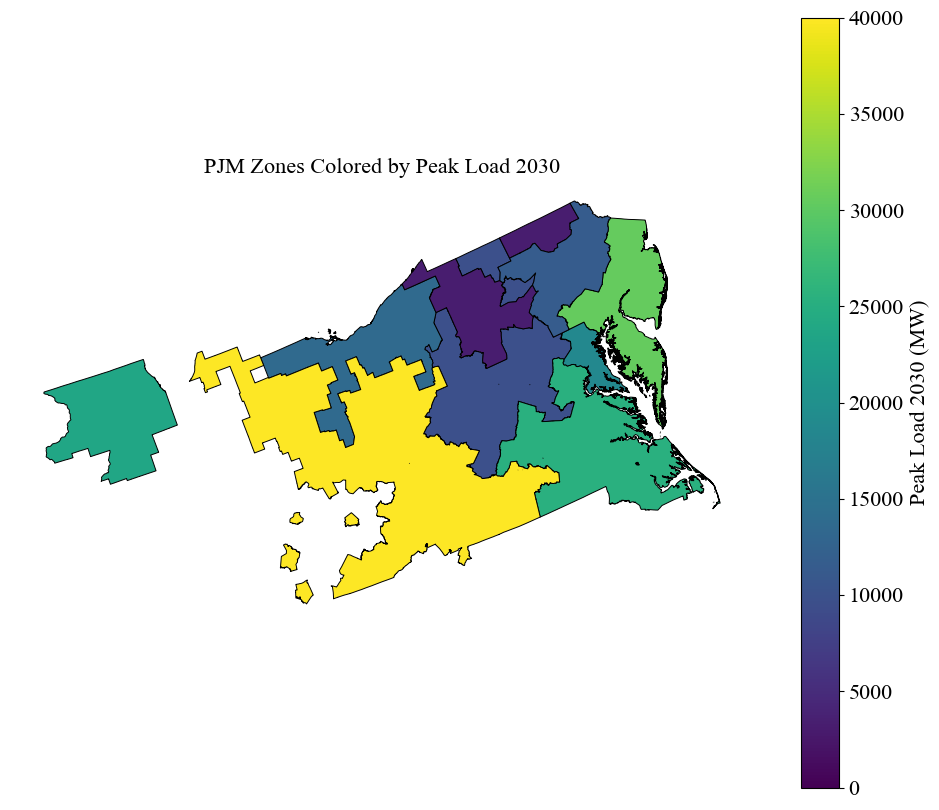

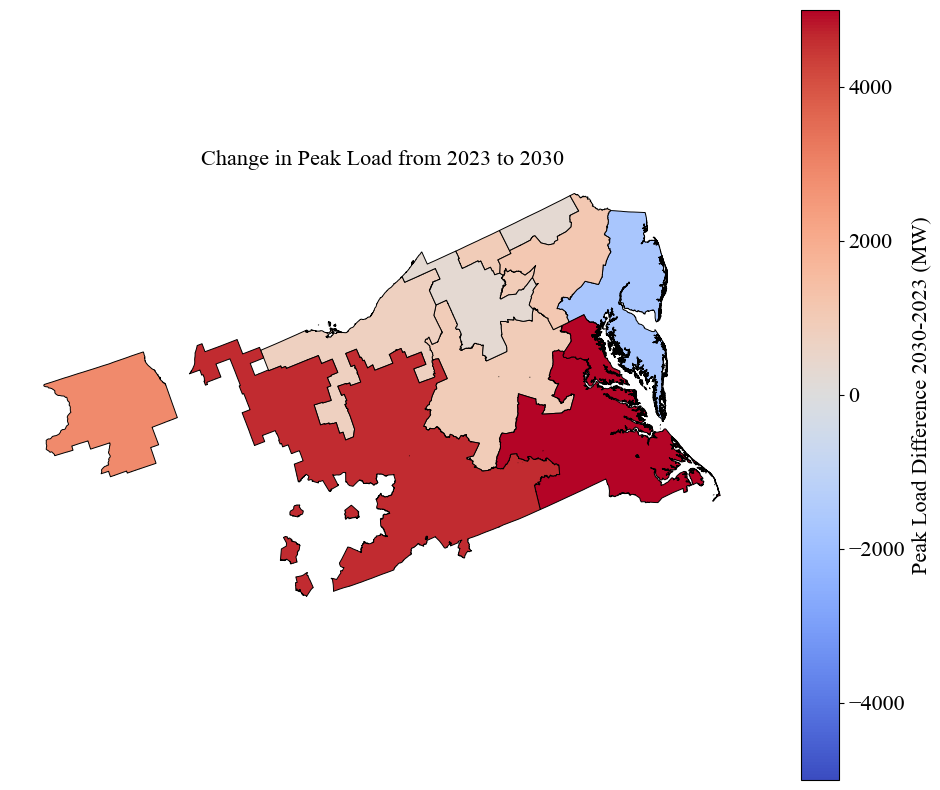

In [17]:

loads_2023 = pd.read_csv(BASE_DIR / 'data/inputs/Base_Case/loads.csv')
loads_2030 = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/load.csv')
zones_2023 = zones.merge(
    loads_2023,
    left_on="IPM_Region",
    right_on="Zone",
    how="left"
)
zones_2030 = zones.merge(
    loads_2030,
    left_on="IPM_Region",
    right_on="PJM_Zone",
    how="left"
)
# Merge 2023 and 2030 loads into zones GeoDataFrame
zones_diff = zones.copy()
zones_diff = zones_diff.merge(
    loads_2023[['Zone', 'Peak_Load']],
    left_on='IPM_Region',
    right_on='Zone',
    how='left'
).merge(
    loads_2030[['PJM_Zone', 'Peak_Load_2030']],
    left_on='IPM_Region',
    right_on='PJM_Zone',
    how='left'
)

# Compute the difference and store in a new column
zones_diff['Load_Diff'] = zones_diff['Peak_Load_2030'] - zones_diff['Peak_Load']

fig, ax = plt.subplots(figsize=(12,10))

# Plot zones with colormap based on load
zones_2023.plot(
    ax=ax,
    column="Peak_Load",
    cmap="viridis",         # choose any colormap
    edgecolor="black",
    linewidth=0.7,
    legend=True,            # shows colorbar
    legend_kwds={"label": "Peak Load 2023 (MW)"},
    vmax=40000,
    vmin= 0
)

ax.set_title("PJM Zones Colored by Peak Load 2030", fontsize=16)
ax.set_axis_off()

plt.show()
fig, ax = plt.subplots(figsize=(12,10))

# Plot zones with colormap based on load
zones_2030.plot(
    ax=ax,
    column="Peak_Load_2030",
    cmap="viridis",         # choose any colormap
    edgecolor="black",
    linewidth=0.7,
    legend=True,            # shows colorbar
    legend_kwds={"label": "Peak Load 2030 (MW)"},
    vmax=40000,
    vmin= 0
)

ax.set_title("PJM Zones Colored by Peak Load 2030", fontsize=16)
ax.set_axis_off()

plt.show()
fig, ax = plt.subplots(figsize=(12,10))

zones_diff.plot(
    ax=ax,
    column='Load_Diff',
    cmap='coolwarm',     # diverging colormap is good for differences
    edgecolor='black',
    linewidth=0.7,
    legend=True,
    legend_kwds={'label': 'Peak Load Difference 2030-2023 (MW)'},
    vmax=5000,
    vmin=-5000
)

ax.set_title("Change in Peak Load from 2023 to 2030", fontsize=16)
ax.set_axis_off()
plt.show()




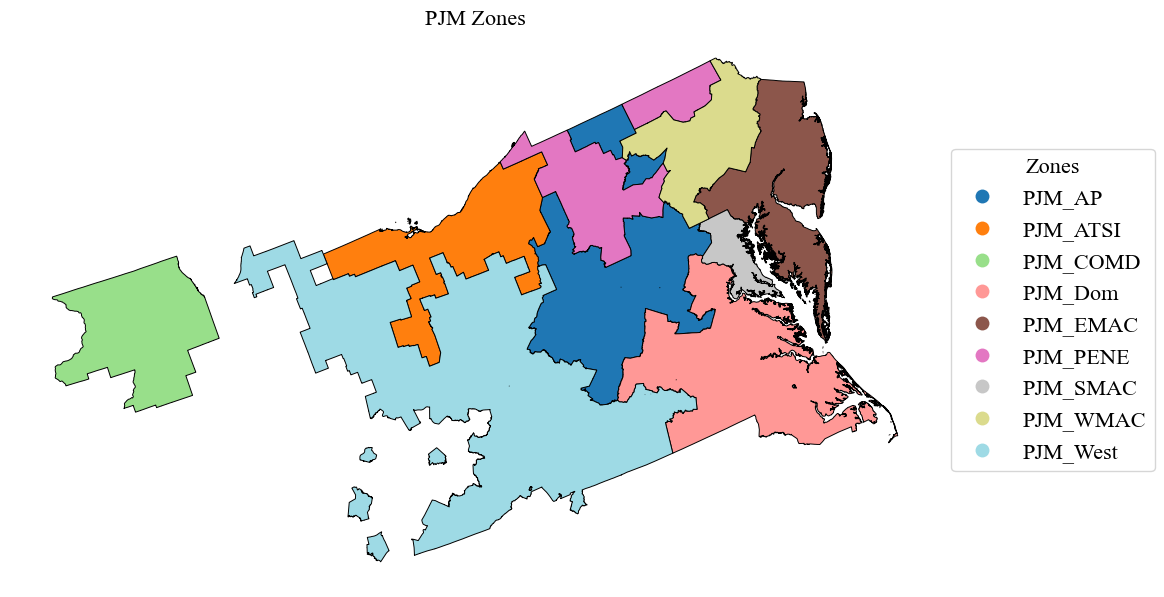

In [ ]:
pjm_zones = ['PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
             'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West']
zones = zones[zones['IPM_Region'].isin(pjm_zones)]

# Plot
fig, ax = plt.subplots(figsize=(12,10))
zones.plot(
    ax=ax,
    column='IPM_Region',    # color by zone
    cmap='tab20',            # categorical colormap
    edgecolor='black',
    linewidth=0.7,
    legend=True,             # show zone names in legend
    legend_kwds={
        'title': 'Zones',
        'loc': 'center left',        # put legend outside
        'bbox_to_anchor': (1, 0.5)   # right of plot, centered vertically
    }
)
ax.set_title("PJM Zones", fontsize=16)
ax.set_axis_off()
plt.show()

# The sensitivity analysis results

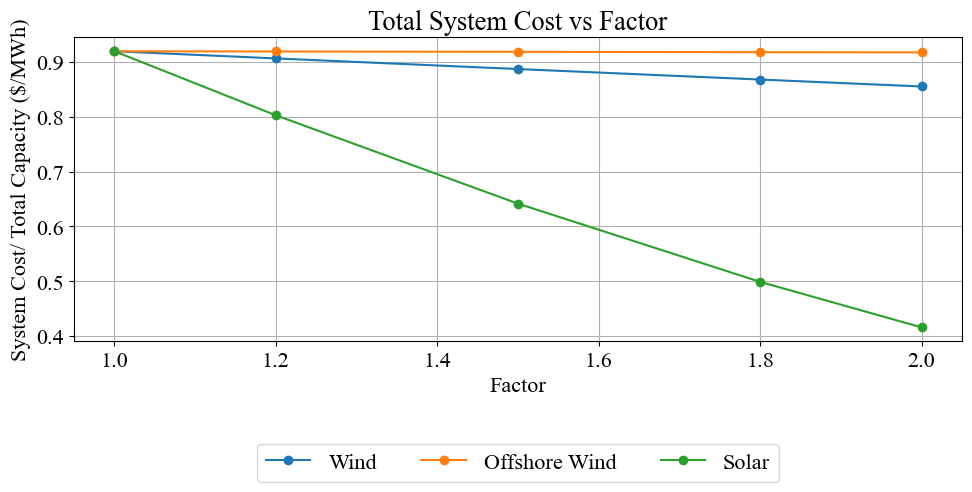

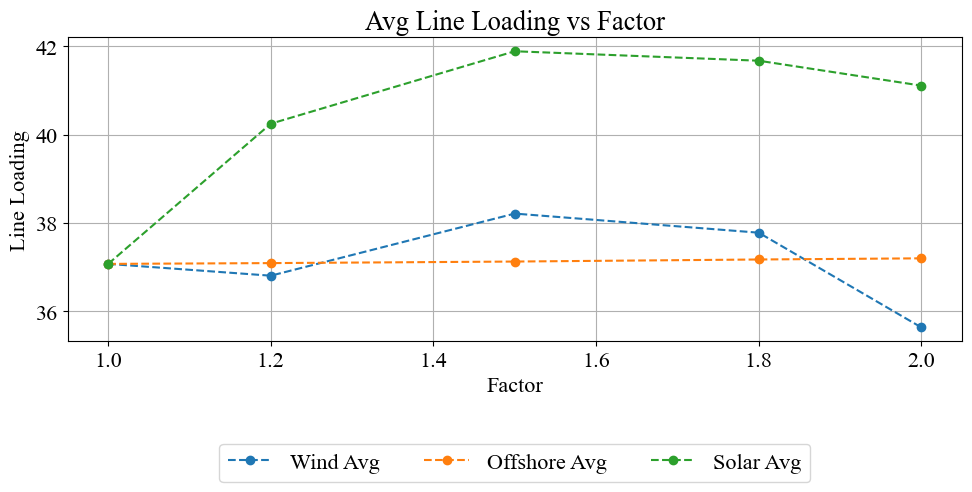

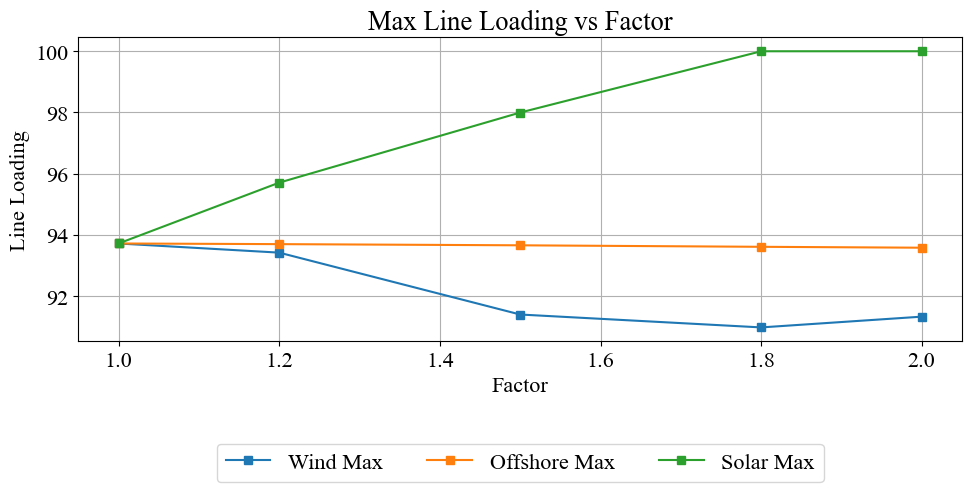

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

factors = [1.0, 1.2, 1.5, 1.8, 2.0]

offshore_sensitivity_data = {'factor': [], 'cost': [], 'avg_loading': [], 'max_loading': [], 'capacity' : []}
wind_sensitivity_data     = {'factor': [], 'cost': [], 'avg_loading': [], 'max_loading': [], 'capacity' : []}
solar_sensitivity_data    = {'factor': [], 'cost': [], 'avg_loading': [], 'max_loading': [], 'capacity' : []}

for factor in factors:
    # Wind --------------------------------------
    filename = BASE_DIR / f"results/line_loads_factor_wind_{factor}.csv"
    wind_df = pd.read_csv(filename)
    wind_sensitivity_data['factor'].append(factor)
    wind_sensitivity_data['cost'].append(wind_df['cost'].iloc[0])
    wind_sensitivity_data['avg_loading'].append(np.mean(wind_df['utilization']))
    wind_sensitivity_data['max_loading'].append(np.max(wind_df['utilization']))
    wind_sensitivity_data['capacity'].append(wind_df['capacity'].iloc[0])

    # Offshore ----------------------------------
    filename = BASE_DIR / f"results/line_loads_factor_{factor}_offshore.csv"
    offshore_df = pd.read_csv(filename)
    offshore_sensitivity_data['factor'].append(factor)
    offshore_sensitivity_data['cost'].append(offshore_df['cost'].iloc[0])
    offshore_sensitivity_data['avg_loading'].append(np.mean(offshore_df['utilization']))
    offshore_sensitivity_data['max_loading'].append(np.max(offshore_df['utilization']))
    offshore_sensitivity_data['capacity'].append(offshore_df['capacity'].iloc[0])

    # Solar -------------------------------------
    filename = BASE_DIR / f"results/line_loads_factor_{factor}_solar.csv"
    solar_df = pd.read_csv(filename)
    solar_sensitivity_data['factor'].append(factor)
    solar_sensitivity_data['cost'].append(solar_df['cost'].iloc[0])
    solar_sensitivity_data['avg_loading'].append(np.mean(solar_df['utilization']))
    solar_sensitivity_data['max_loading'].append(np.max(solar_df['utilization']))
    solar_sensitivity_data['capacity'].append(solar_df['capacity'].iloc[0])



# Convert to DataFrames for cleaner plotting
wind_df_plot     = pd.DataFrame(wind_sensitivity_data)
offshore_df_plot = pd.DataFrame(offshore_sensitivity_data)
solar_df_plot    = pd.DataFrame(solar_sensitivity_data)

# ============================
# 1. PLOT: FACTOR vs COST
# ============================

plt.figure(figsize=(10,6))
plt.plot(wind_df_plot['factor'], wind_df_plot['cost']/wind_df_plot['capacity'], '-o', label='Wind')
plt.plot(offshore_df_plot['factor'], offshore_df_plot['cost']/offshore_df_plot['capacity'], '-o', label='Offshore Wind')
plt.plot(solar_df_plot['factor'], solar_df_plot['cost']/solar_df_plot['capacity'], '-o', label='Solar')

plt.xlabel('Factor')
plt.ylabel('System Cost/ Total Capacity ($/MWh)')
plt.title('Total System Cost vs Factor')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.tight_layout()
plt.show()


# ============================
# 2. PLOT: AVG & MAX LOADING
# ============================

plt.figure(figsize=(10,6))

# Average loading
plt.plot(wind_df_plot['factor'], wind_df_plot['avg_loading'], 'o--', label='Wind Avg')
plt.plot(offshore_df_plot['factor'], offshore_df_plot['avg_loading'], 'o--', label='Offshore Avg')
plt.plot(solar_df_plot['factor'], solar_df_plot['avg_loading'], 'o--', label='Solar Avg')

plt.xlabel('Factor')
plt.ylabel('Line Loading')
plt.title('Avg Line Loading vs Factor')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.tight_layout()
plt.show()
plt.figure(figsize=(10,6))
# Max loading
plt.plot(wind_df_plot['factor'], wind_df_plot['max_loading'], 's-', label='Wind Max')
plt.plot(offshore_df_plot['factor'], offshore_df_plot['max_loading'], 's-', label='Offshore Max')
plt.plot(solar_df_plot['factor'], solar_df_plot['max_loading'], 's-', label='Solar Max')

plt.xlabel('Factor')
plt.ylabel('Line Loading')
plt.title('Max Line Loading vs Factor')
plt.grid(True)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)

plt.tight_layout()
plt.show()


# Wind's effect on congestion

Index(['IPM_Region', 'geometry'], dtype='object')
Index(['Unnamed: 0', 'Zone_numbers', 'Network_zones', 'Network_Lines',
       'Start_Zone', 'End_Zone', 'Line_Max_Flow_MW', 'transmission_path_name',
       'distance_mile', 'Line_Loss_Percentage', 'Line_Max_Reinforcement_MW',
       'Line_Reinforcement_Cost_per_MWyr', 'DerateCapRes_1', 'CapRes_Excl_1',
       'branch_idx'],
      dtype='object')


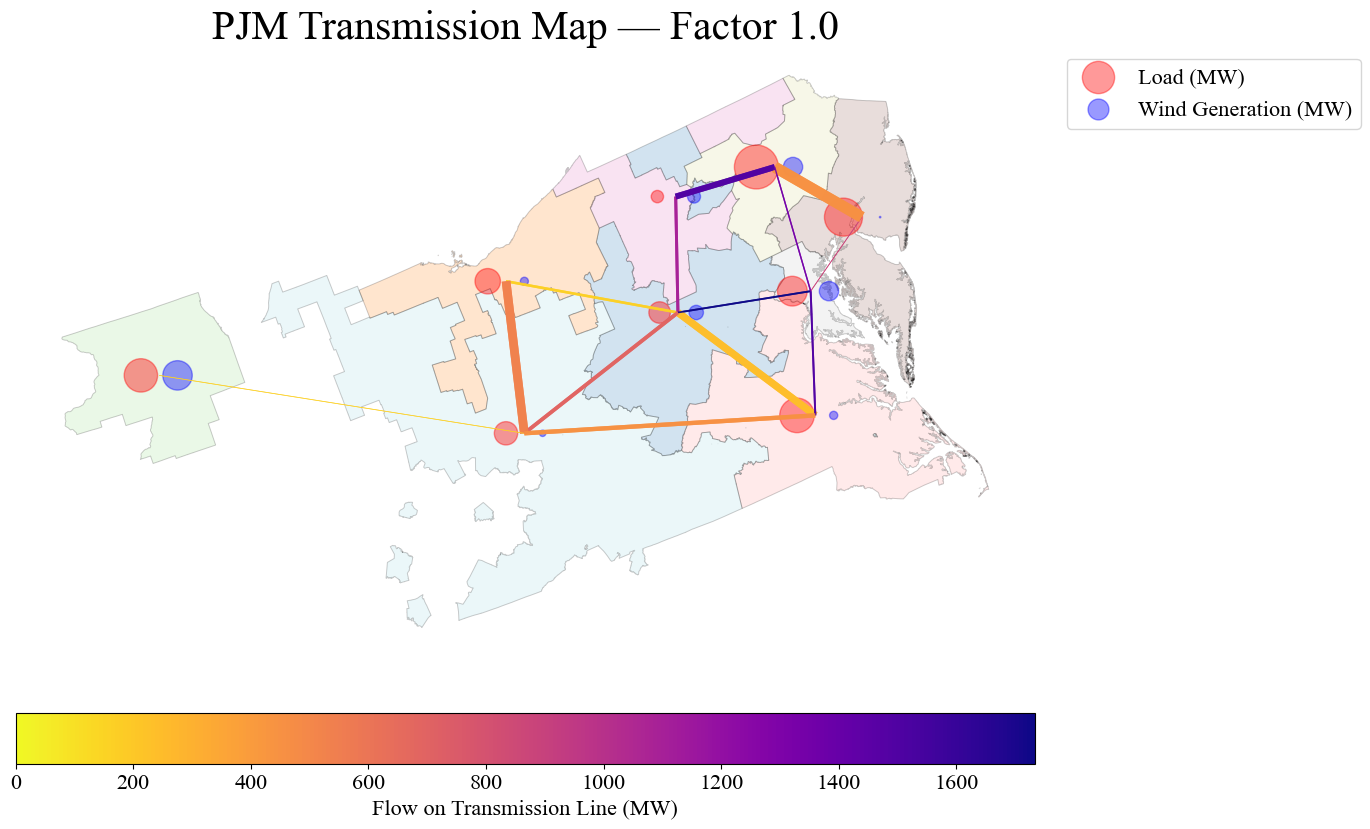

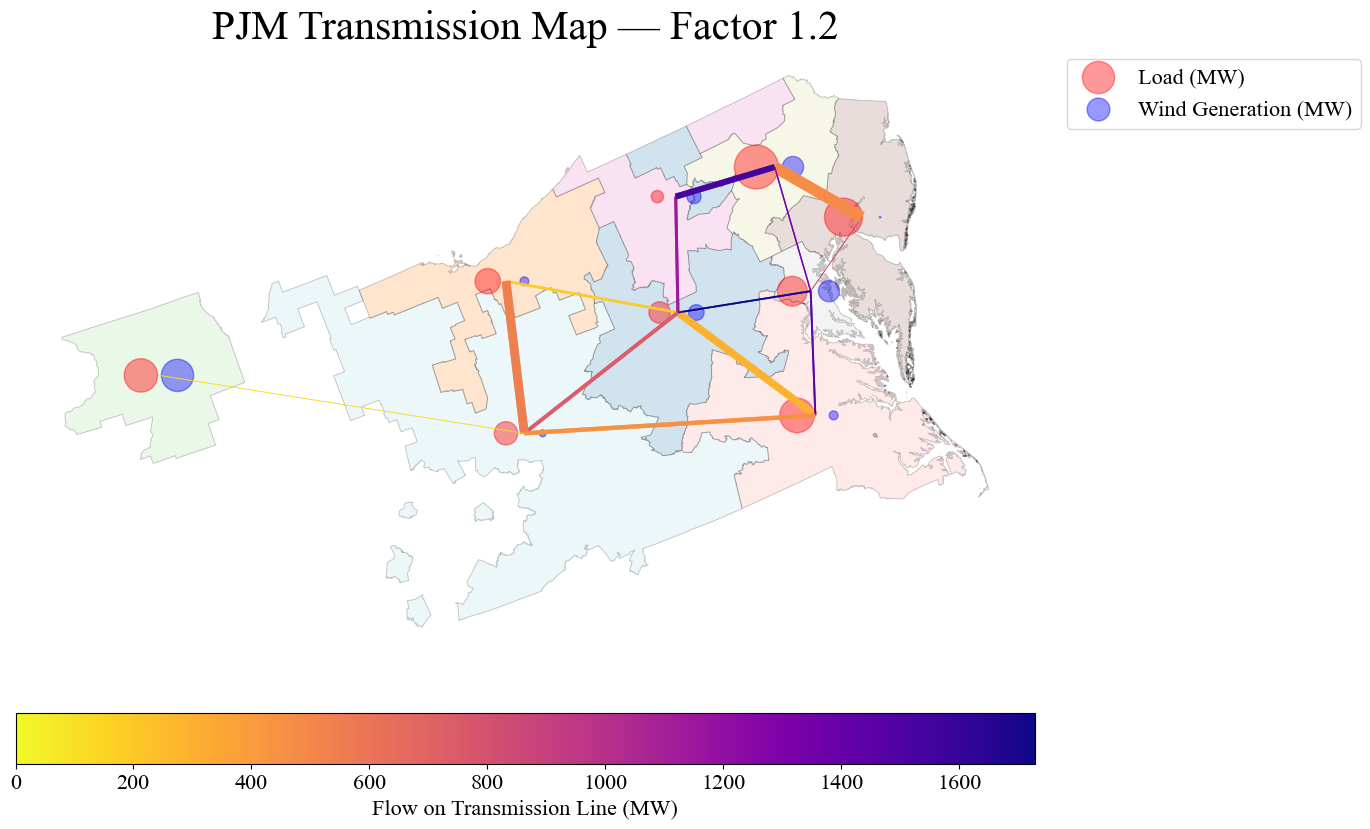

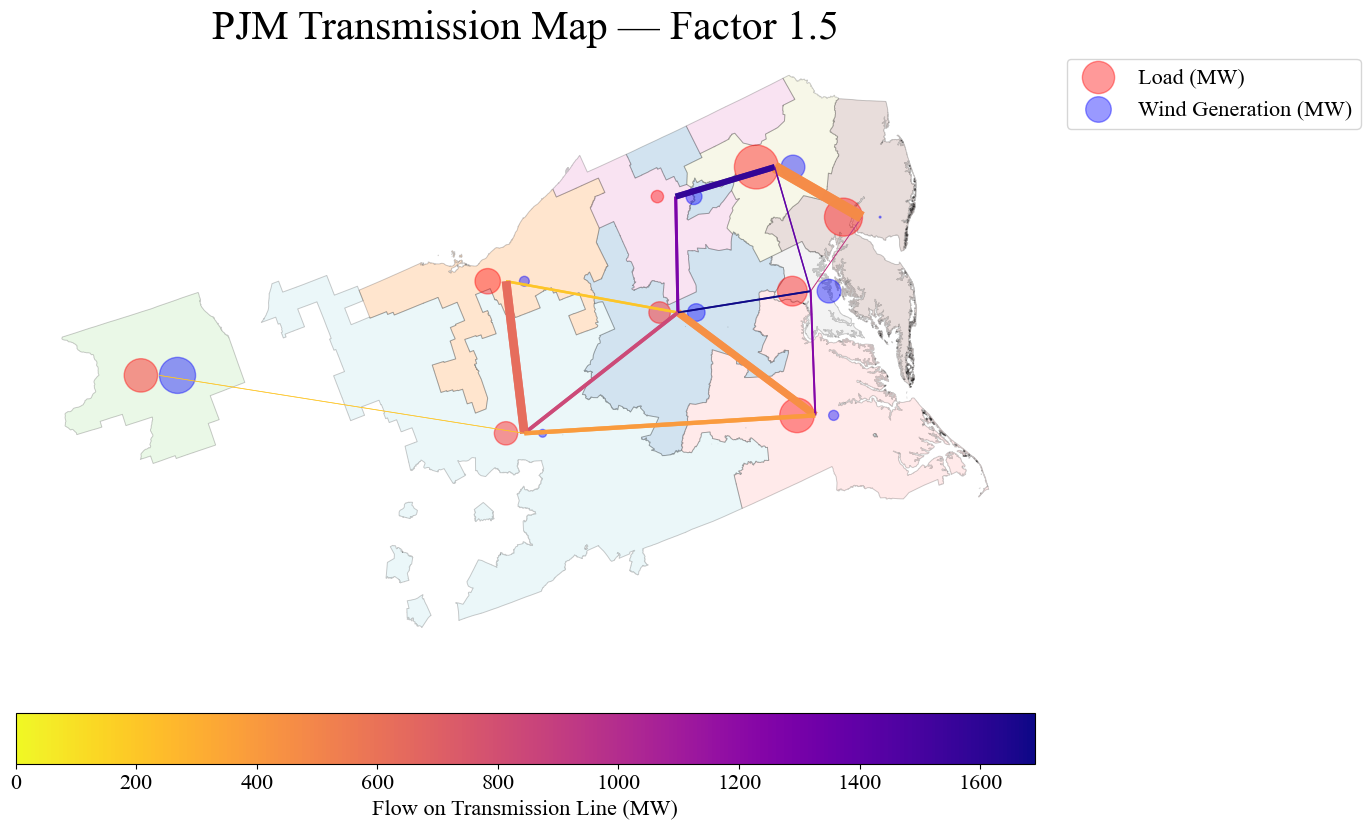

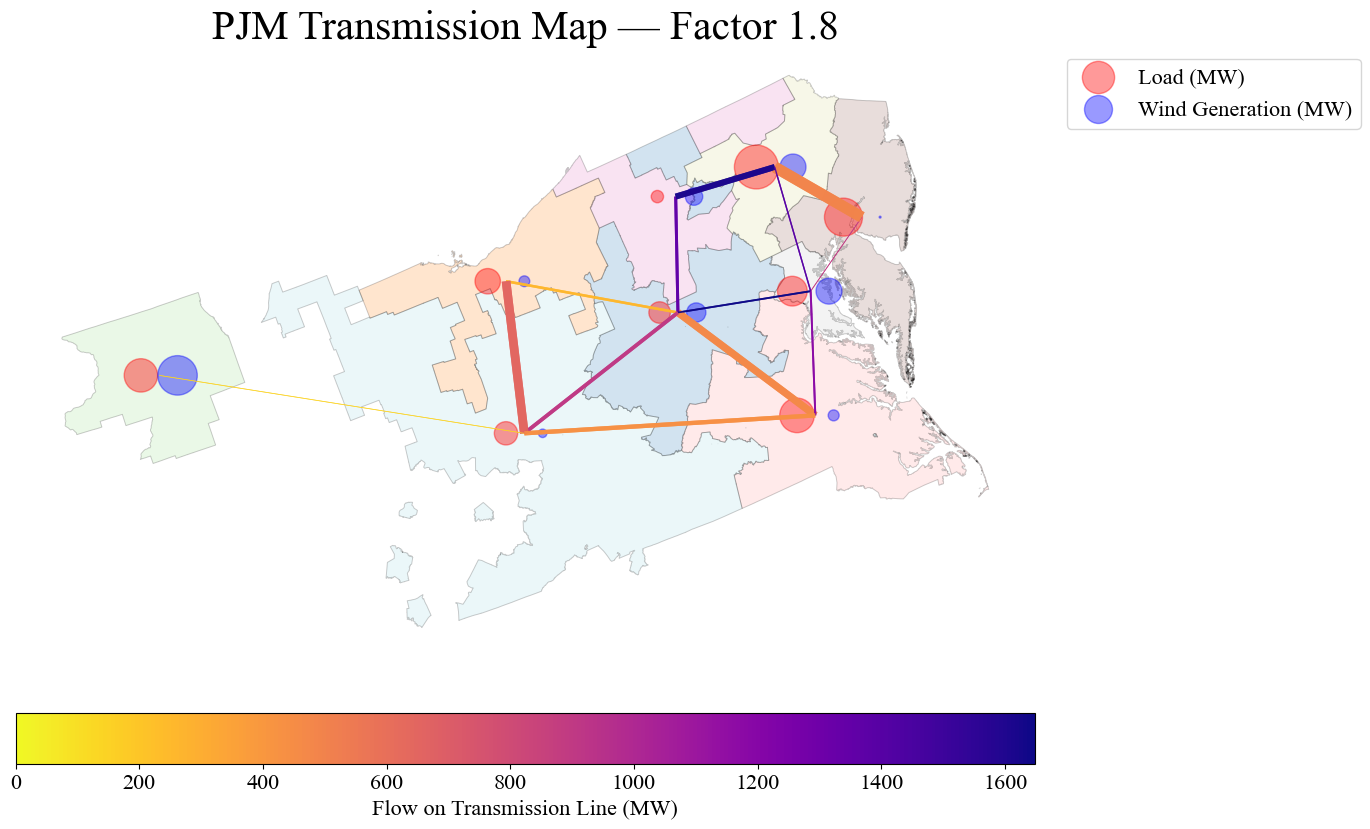

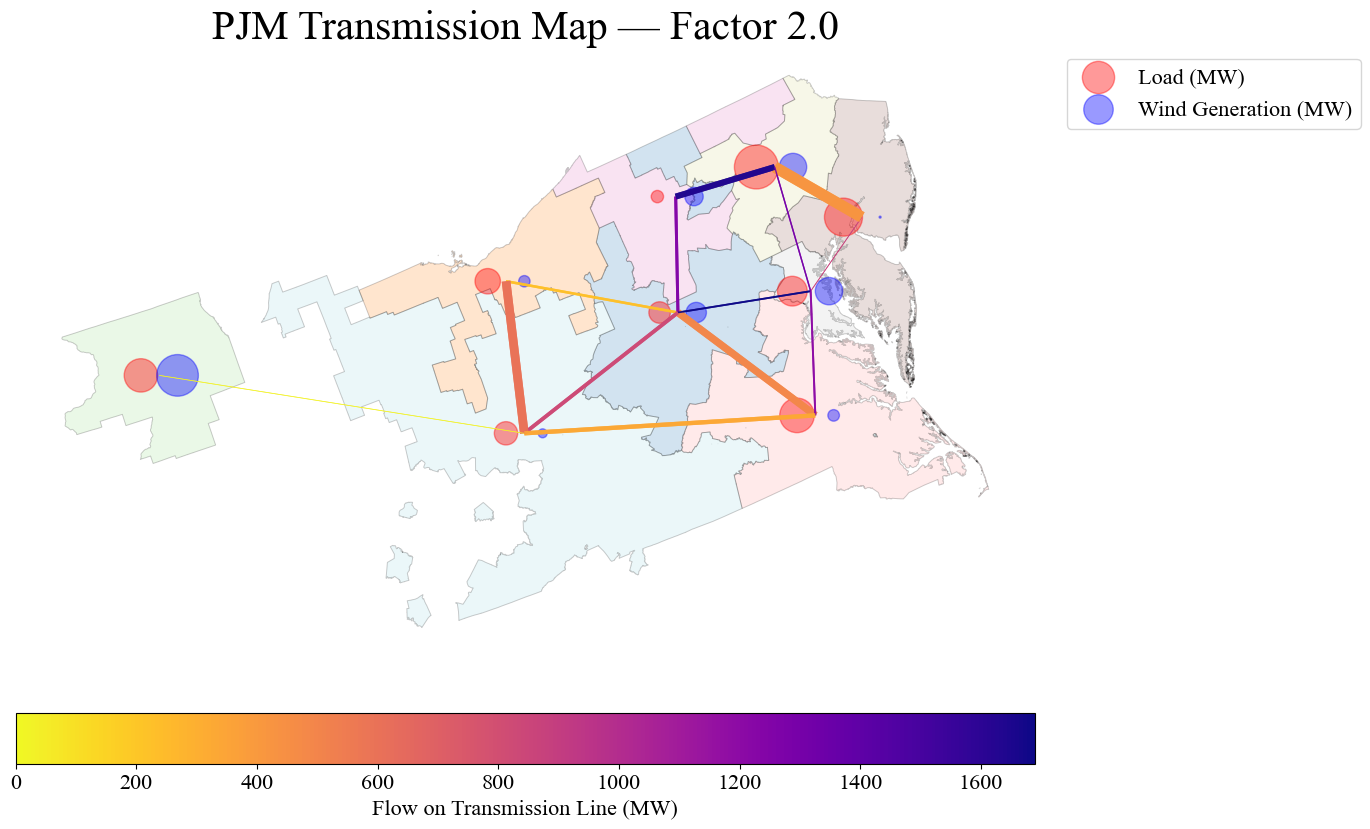

In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------
# 1. READ THE SHAPEFILE
# ----------------------
# --------------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------------
shp_path = BASE_DIR / "data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp"   # change this to your file
zones = gpd.read_file(shp_path)

# ----------------------
# 2. READ NETWORK LINES
# ----------------------


network_path = BASE_DIR / "data/inputs/Planned_Case/Network_modified.csv"
network = pd.read_csv(network_path)

zones_keep = [
    'PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
    'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West'
]

# Inspect columns
print(zones.columns)
print(network.columns)

zones = zones[zones['IPM_Region'].isin(zones_keep)]

zones["centroid"] = zones.geometry.centroid

# Build a FAST lookup table
centroid_map = dict(zip(zones["IPM_Region"], zones["centroid"]))



loads = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/load.csv')





# Optional: check zone names
network["Start_Zone"] = network["Start_Zone"].str.strip()
network["End_Zone"]   = network["End_Zone"].str.strip()


# -------------------------
# 3. BUILD ALL LINESTRINGS
# -------------------------
def make_line(start_zone, end_zone):
    if start_zone not in centroid_map or end_zone not in centroid_map:
        return None
    return LineString([centroid_map[start_zone], centroid_map[end_zone]])

network["geometry"] = network.apply(
    lambda row: make_line(row["Start_Zone"], row["End_Zone"]),
    axis=1
)

# Remove lines that failed
network = network[network["geometry"].notna()].copy()
network = gpd.GeoDataFrame(network, geometry="geometry", crs=zones.crs)


# --------------------------
# 4. SCALE LINE THICKNESS
# --------------------------
cap = pd.to_numeric(network["Line_Max_Flow_MW"], errors="coerce")

cap_min, cap_max = cap.min(), cap.max()
network["line_width"] = 0.5 + (cap - cap_min) / (cap_max - cap_min) * (8 - 0.5)


factor = 1.0

for factor in factors:
    gens  = pd.read_csv(BASE_DIR / f"data/inputs/Planned_Case/combined_generation_modified_wind_{factor}.csv")            # columns: PJM_Zone, Total_Gen_2030
    flows = pd.read_csv(BASE_DIR / f"results/line_loads_factor_wind_{factor}.csv")          # columns: line_id, flow_MW
    
    gens['ZONE'] = gens['ZONE'].str.strip()
    gens = gens[gens['ZONE'].isin(zones_keep)]
    gens_wind= gens.loc[gens['FUEL_TYPE']== 'WND','PMAX']
    # --------------------------------------------------------
    # 3. PREP FIGURE
    # --------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 12))

    # --------------------------------------------------------
    # 4. PLOT ZONES IN BLACK & WHITE
    # --------------------------------------------------------
    zones.plot(
        ax=ax,
        column='IPM_Region',    # color by zone
        cmap='tab20',            # categorical colormap
        edgecolor='black',
        linewidth=0.7,
        legend=True,             # show zone names in legend
        alpha=0.2
    )
    global_max = np.max(flows["flow"].values)
    global_min = np.min(flows["flow"].values)


    # Attach flows (same row order)
    network["flow"] = flows["flow"].values

    # Lines colored by flow
    network.plot(
        ax=ax,
        column="flow",
        cmap="plasma_r",
        linewidth=network["line_width"],  # works now
        alpha=0.9,
        vmin = 0,
        vmax= global_max
    )

    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap="plasma_r",
        norm=plt.Normalize(vmin=0, vmax=global_max)
    )
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label("Flow on Transmission Line (MW)")



    zone_centroids = zones.geometry.centroid

    # Normalize sizes
    load_size = loads["Peak_Load_2030"].values
    gen_size  = gens_wind.values

    load_s = 1000 * (load_size / load_size.max())   # circle area scaling
    gen_s  = 10000 * (gen_size  / load_size.max())
    offset = 30000  
    load_x = zone_centroids.x - offset
    gen_x  = zone_centroids.x + offset
    # LOAD = red circles
    ax.scatter(
        load_x,
        zone_centroids.y,
        s=load_s,
        color="red",
        alpha=0.4,
        label="Load (MW)"
    )

    # GENERATION = blue circles
    ax.scatter(
        gen_x,
        zone_centroids.y,
        s=gen_s,
        color="blue",
        alpha=0.4,
        label="Wind Generation (MW)"
    )

    # --------------------------------------------------------
    # 8. LEGEND OUTSIDE
    # --------------------------------------------------------
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True
    )

    # --------------------------------------------------------
    # 9. FINISH
    # --------------------------------------------------------
    ax.set_title(f"PJM Transmission Map — Factor {factor}", fontsize=30)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()




# Solar's effect on congestion

Index(['IPM_Region', 'geometry'], dtype='object')
Index(['Unnamed: 0', 'Zone_numbers', 'Network_zones', 'Network_Lines',
       'Start_Zone', 'End_Zone', 'Line_Max_Flow_MW', 'transmission_path_name',
       'distance_mile', 'Line_Loss_Percentage', 'Line_Max_Reinforcement_MW',
       'Line_Reinforcement_Cost_per_MWyr', 'DerateCapRes_1', 'CapRes_Excl_1',
       'branch_idx'],
      dtype='object')


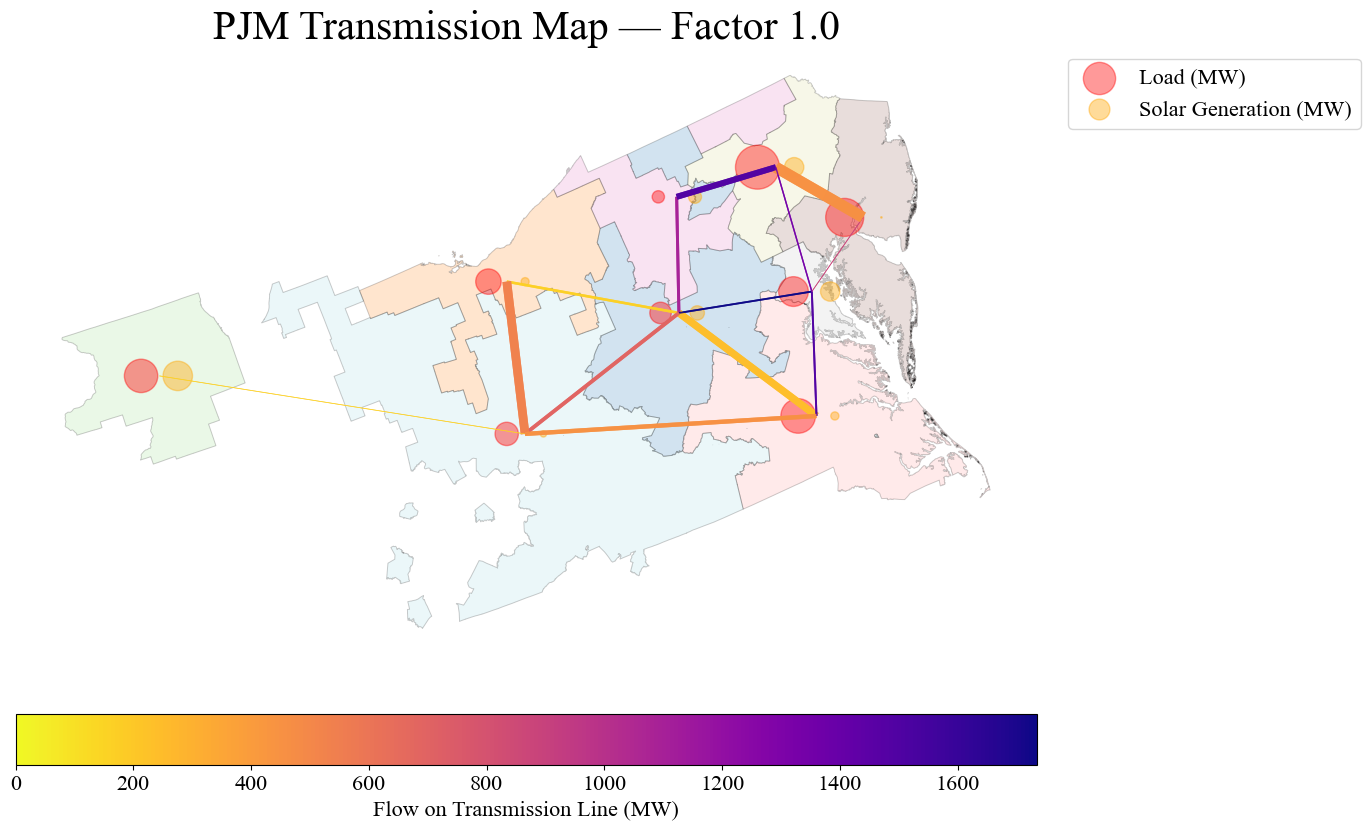

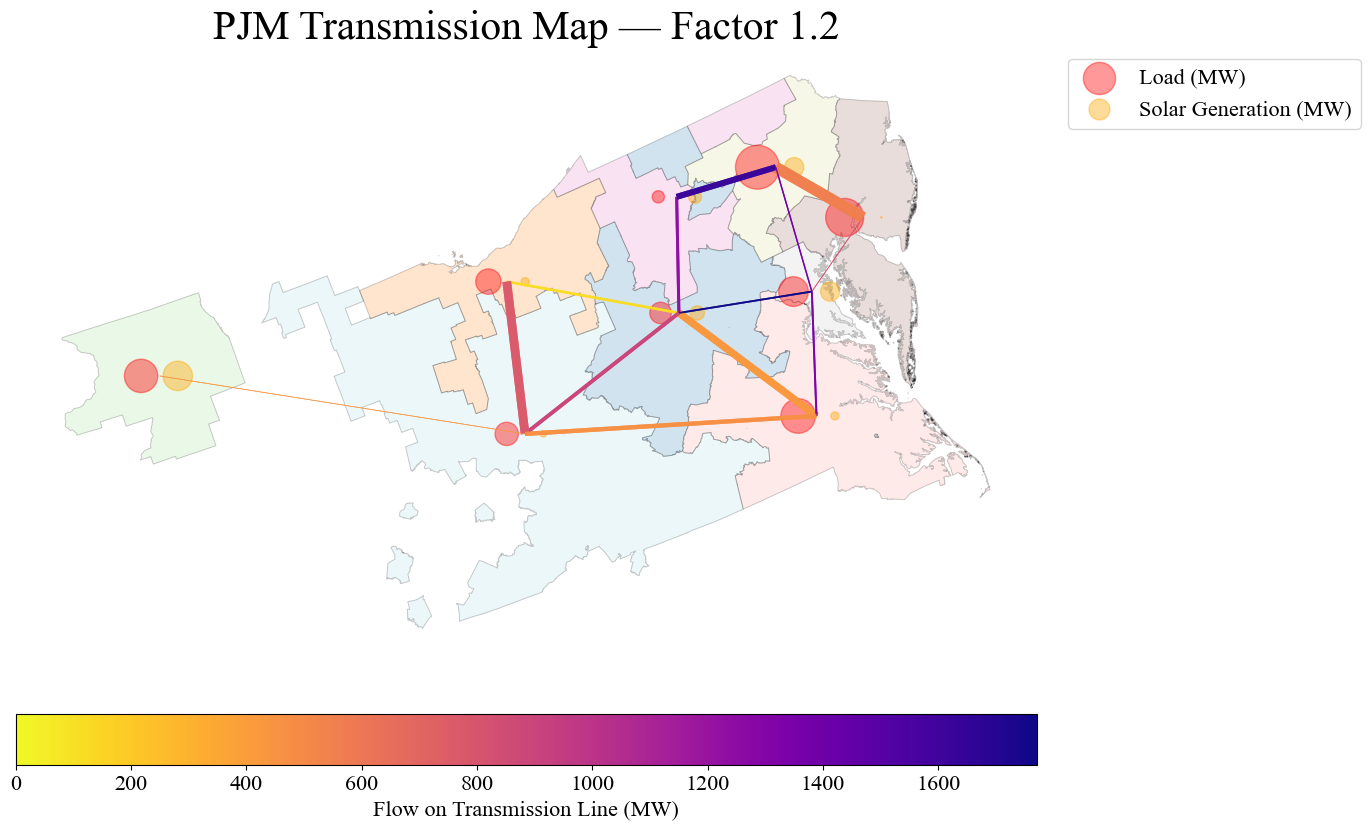

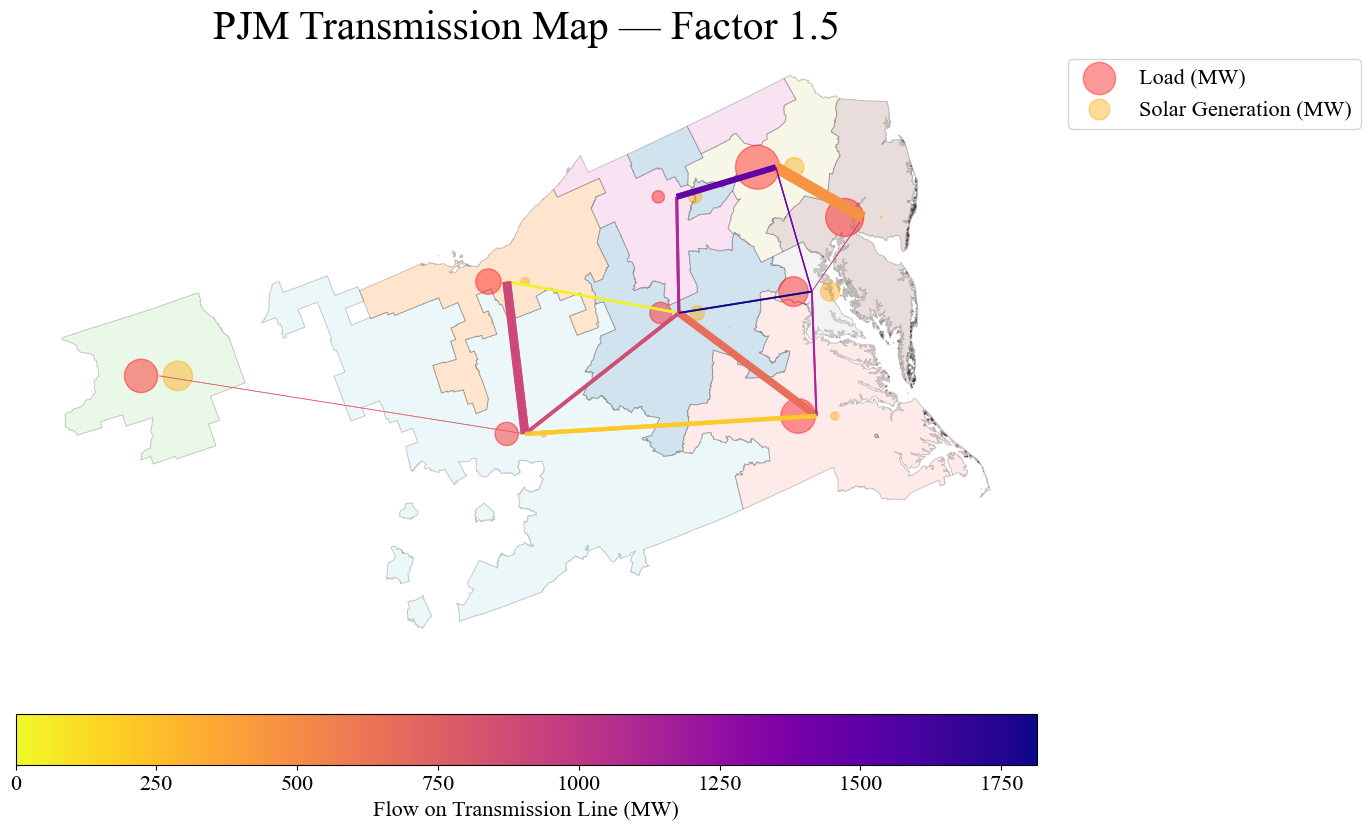

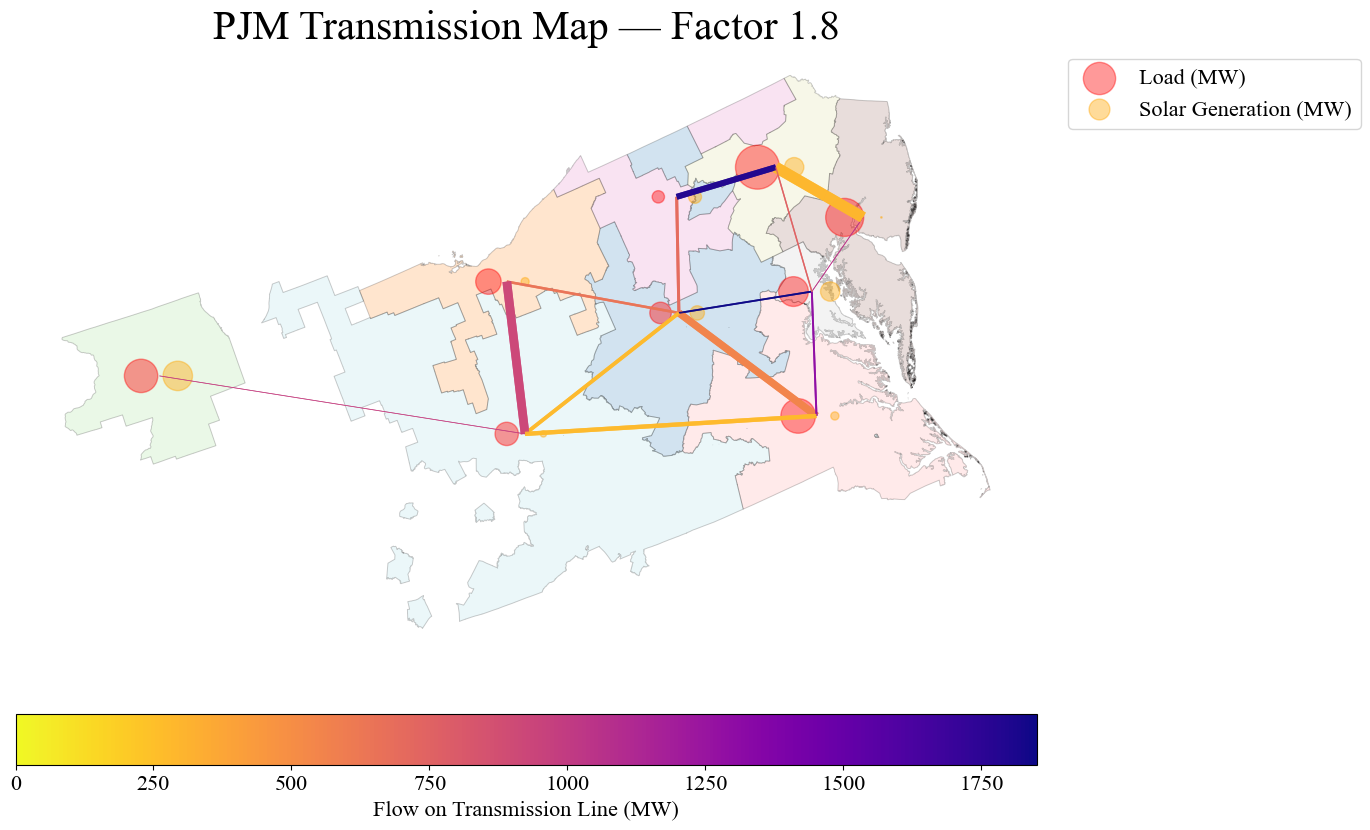

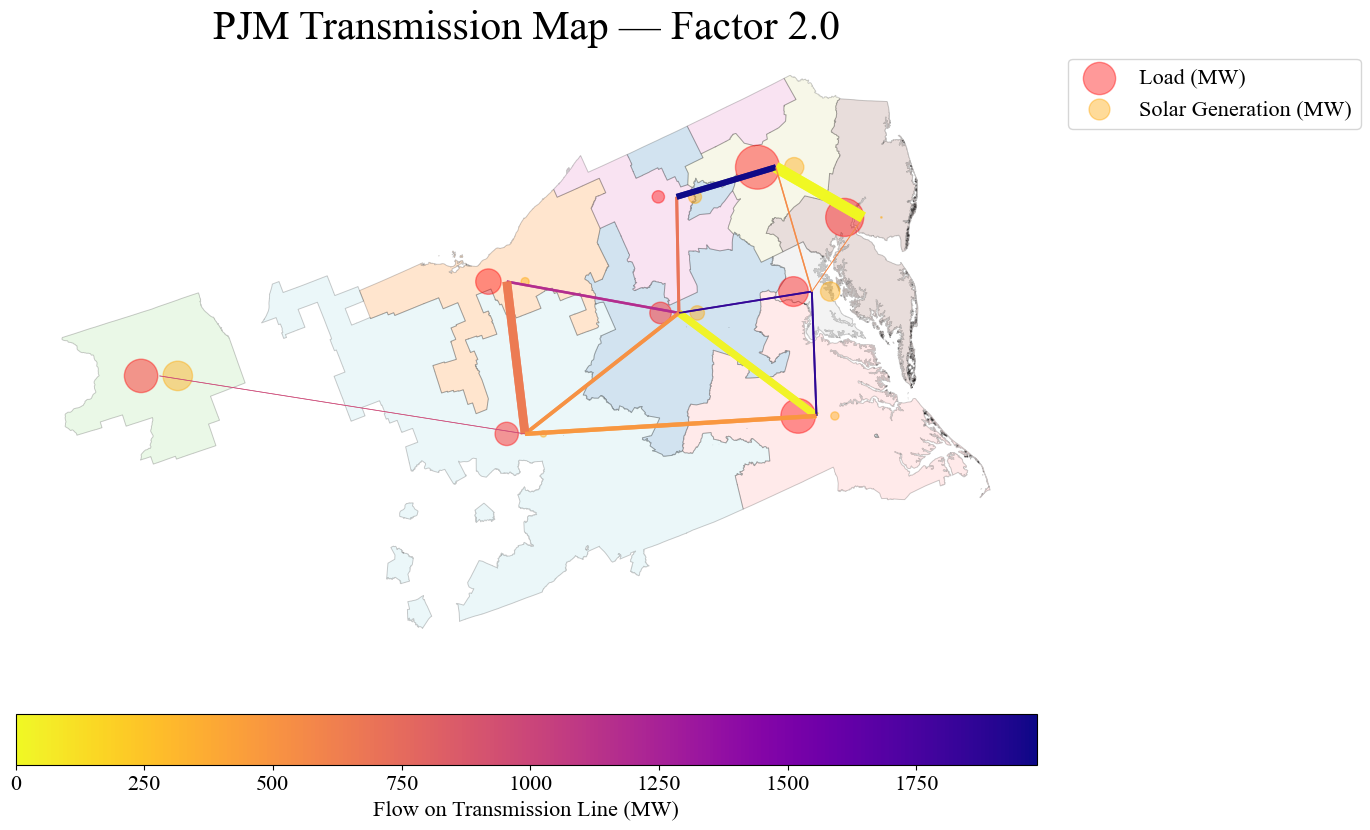

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------
# 1. READ THE SHAPEFILE
# ----------------------
# --------------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------------
shp_path = BASE_DIR / "data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp"   # change this to your file
zones = gpd.read_file(shp_path)

# ----------------------
# 2. READ NETWORK LINES
# ----------------------


network_path = BASE_DIR / "data/inputs/Planned_Case/Network_modified.csv"
network = pd.read_csv(network_path)

zones_keep = [
    'PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
    'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West'
]

# Inspect columns
print(zones.columns)
print(network.columns)

zones = zones[zones['IPM_Region'].isin(zones_keep)]

zones["centroid"] = zones.geometry.centroid

# Build a FAST lookup table
centroid_map = dict(zip(zones["IPM_Region"], zones["centroid"]))



loads = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/load.csv')





# Optional: check zone names
network["Start_Zone"] = network["Start_Zone"].str.strip()
network["End_Zone"]   = network["End_Zone"].str.strip()


# -------------------------
# 3. BUILD ALL LINESTRINGS
# -------------------------
def make_line(start_zone, end_zone):
    if start_zone not in centroid_map or end_zone not in centroid_map:
        return None
    return LineString([centroid_map[start_zone], centroid_map[end_zone]])

network["geometry"] = network.apply(
    lambda row: make_line(row["Start_Zone"], row["End_Zone"]),
    axis=1
)

# Remove lines that failed
network = network[network["geometry"].notna()].copy()
network = gpd.GeoDataFrame(network, geometry="geometry", crs=zones.crs)


# --------------------------
# 4. SCALE LINE THICKNESS
# --------------------------
cap = pd.to_numeric(network["Line_Max_Flow_MW"], errors="coerce")

cap_min, cap_max = cap.min(), cap.max()
network["line_width"] = 0.5 + (cap - cap_min) / (cap_max - cap_min) * (8 - 0.5)


factor = 1.0

for factor in factors:
    gens  = pd.read_csv(BASE_DIR / f"data/inputs/Planned_Case/combined_generation_modified_solar_{factor}.csv")            # columns: PJM_Zone, Total_Gen_2030
    flows = pd.read_csv(BASE_DIR / f"results/line_loads_factor_{factor}_solar.csv")          # columns: line_id, flow_MW
    
    gens['ZONE'] = gens['ZONE'].str.strip()
    gens = gens[gens['ZONE'].isin(zones_keep)]
    gens_wind= gens.loc[gens['FUEL_TYPE']== 'WND','PMAX']
    # --------------------------------------------------------
    # 3. PREP FIGURE
    # --------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 12))

    # --------------------------------------------------------
    # 4. PLOT ZONES IN BLACK & WHITE
    # --------------------------------------------------------
    zones.plot(
        ax=ax,
        column='IPM_Region',    # color by zone
        cmap='tab20',            # categorical colormap
        edgecolor='black',
        linewidth=0.7,
        legend=True,             # show zone names in legend
        alpha=0.2
    )
    global_max = np.max(flows["flow"].values)
    global_min = np.min(flows["flow"].values)


    # Attach flows (same row order)
    network["flow"] = flows["flow"].values

    # Lines colored by flow
    network.plot(
        ax=ax,
        column="flow",
        cmap="plasma_r",
        linewidth=network["line_width"],  # works now
        alpha=0.9,
        vmin = 0,
        vmax= global_max
    )

    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap="plasma_r",
        norm=plt.Normalize(vmin=0, vmax=global_max)
    )
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label("Flow on Transmission Line (MW)")



    zone_centroids = zones.geometry.centroid

    # Normalize sizes
    load_size = loads["Peak_Load_2030"].values
    gen_size  = gens_wind.values

    load_s = 1000 * (load_size / load_size.max())   # circle area scaling
    gen_s  = 10000 * (gen_size  / load_size.max())
    offset = 30000  
    load_x = zone_centroids.x - offset
    gen_x  = zone_centroids.x + offset
    # LOAD = red circles
    ax.scatter(
        load_x,
        zone_centroids.y,
        s=load_s,
        color="red",
        alpha=0.4,
        label="Load (MW)"
    )

    # GENERATION = blue circles
    ax.scatter(
        gen_x,
        zone_centroids.y,
        s=gen_s,
        color="orange",
        alpha=0.4,
        label="Solar Generation (MW)"
    )

    # --------------------------------------------------------
    # 8. LEGEND OUTSIDE
    # --------------------------------------------------------
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True
    )

    # --------------------------------------------------------
    # 9. FINISH
    # --------------------------------------------------------
    ax.set_title(f"PJM Transmission Map — Factor {factor}", fontsize=30)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()




# Offshore's effect on congestion

Index(['IPM_Region', 'geometry'], dtype='object')
Index(['Unnamed: 0', 'Zone_numbers', 'Network_zones', 'Network_Lines',
       'Start_Zone', 'End_Zone', 'Line_Max_Flow_MW', 'transmission_path_name',
       'distance_mile', 'Line_Loss_Percentage', 'Line_Max_Reinforcement_MW',
       'Line_Reinforcement_Cost_per_MWyr', 'DerateCapRes_1', 'CapRes_Excl_1',
       'branch_idx'],
      dtype='object')


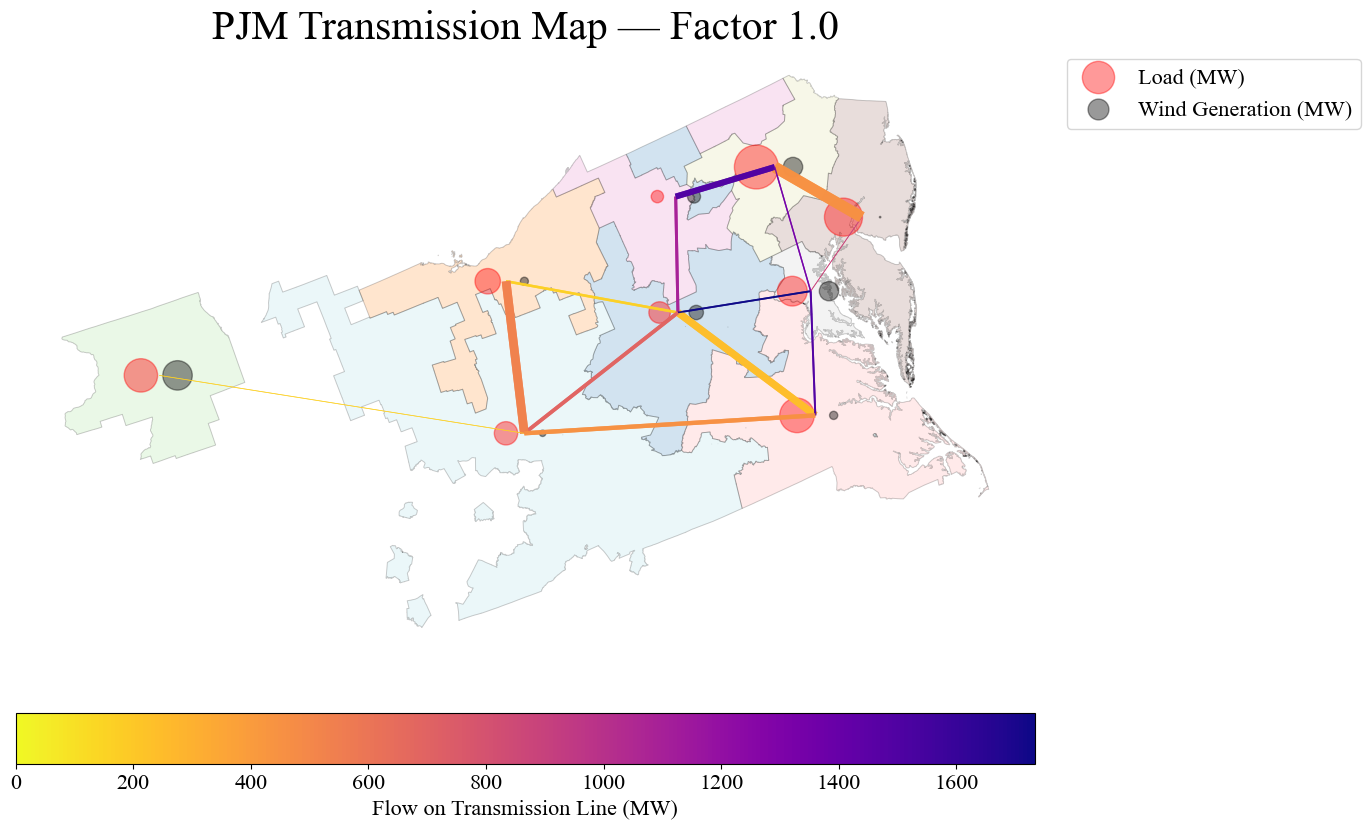

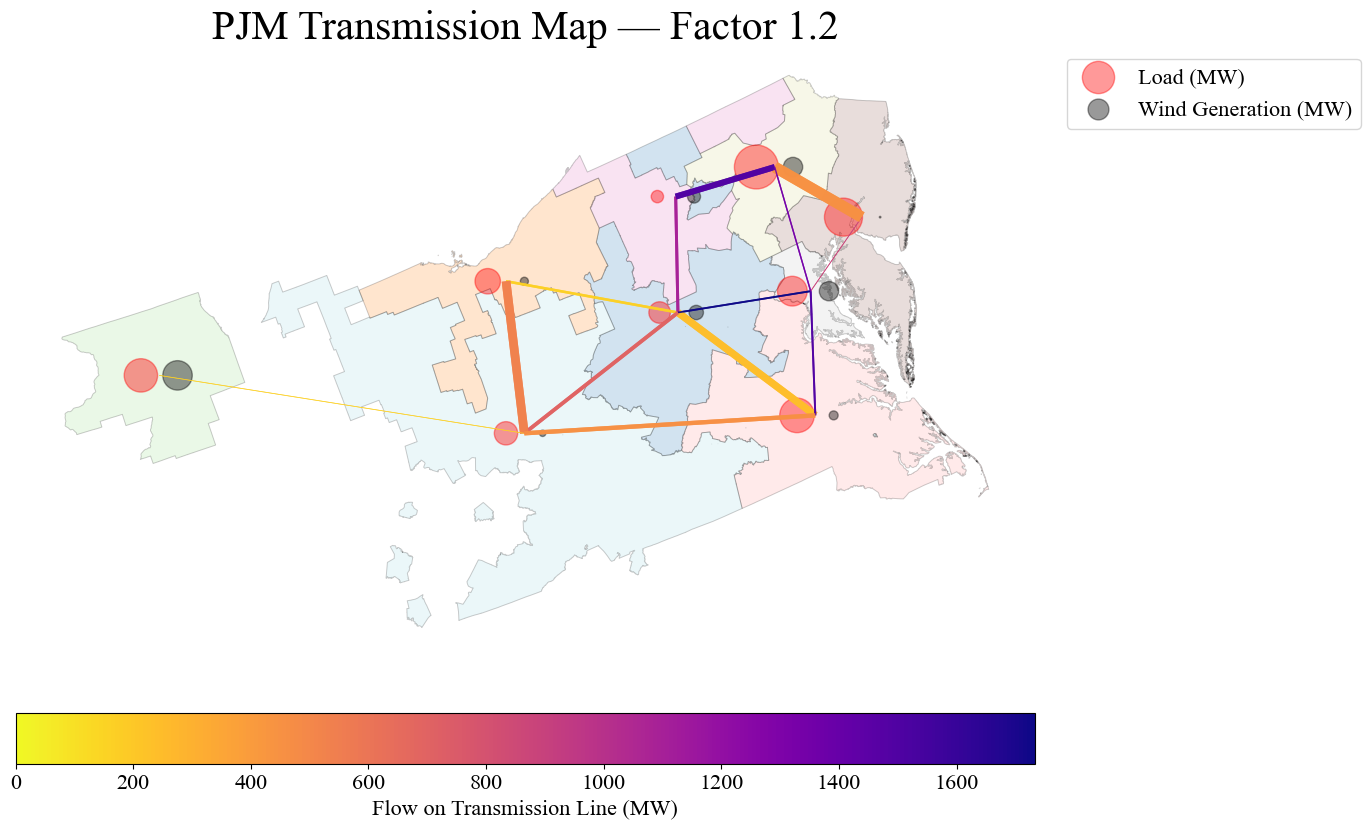

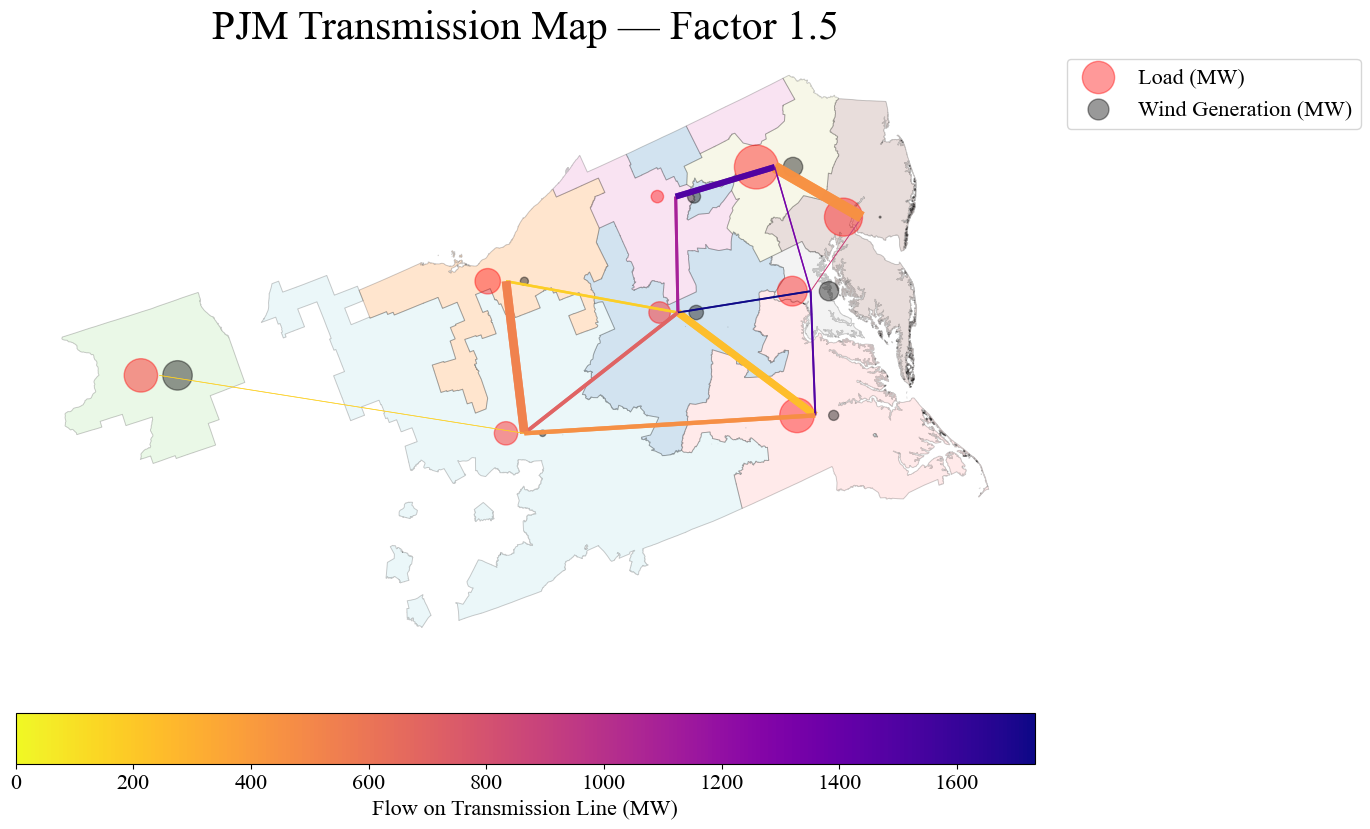

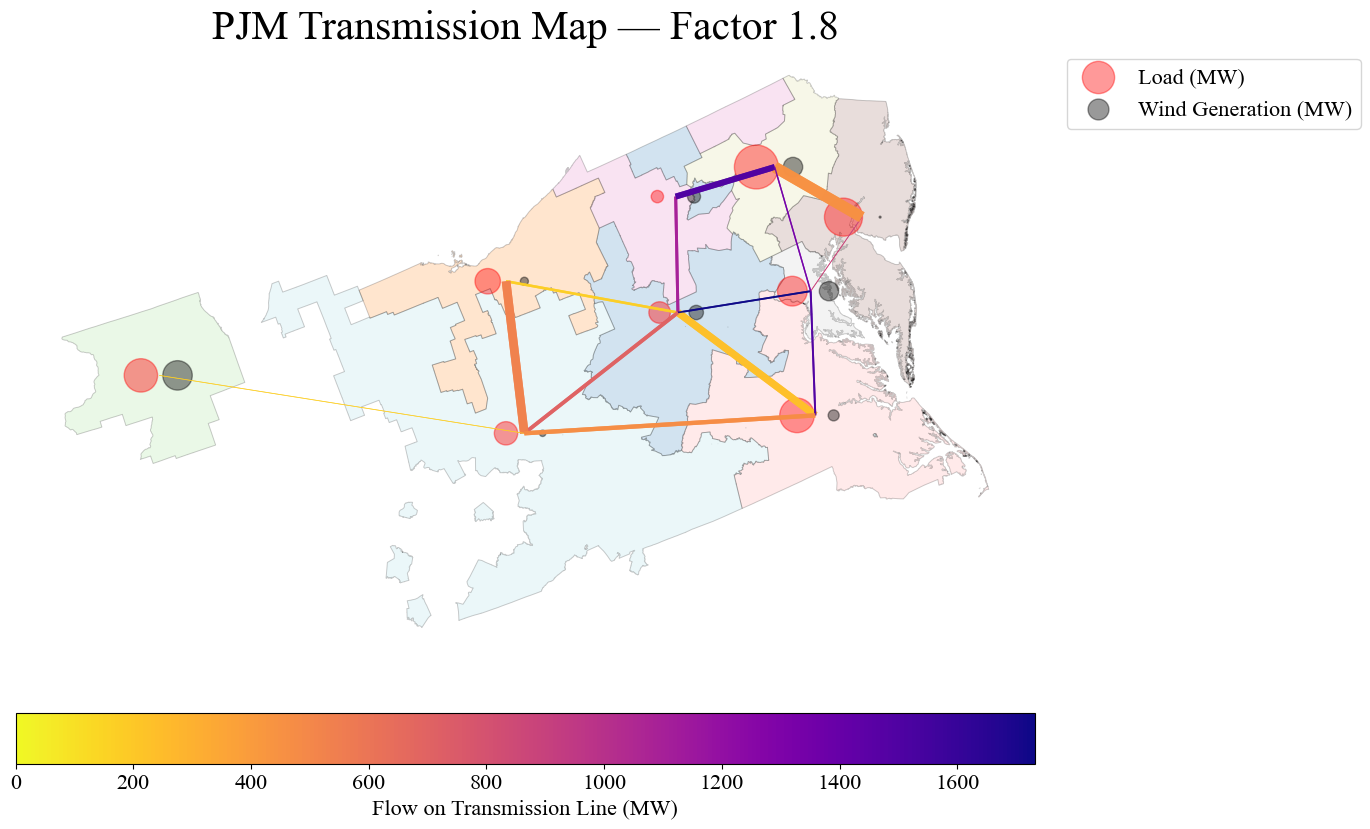

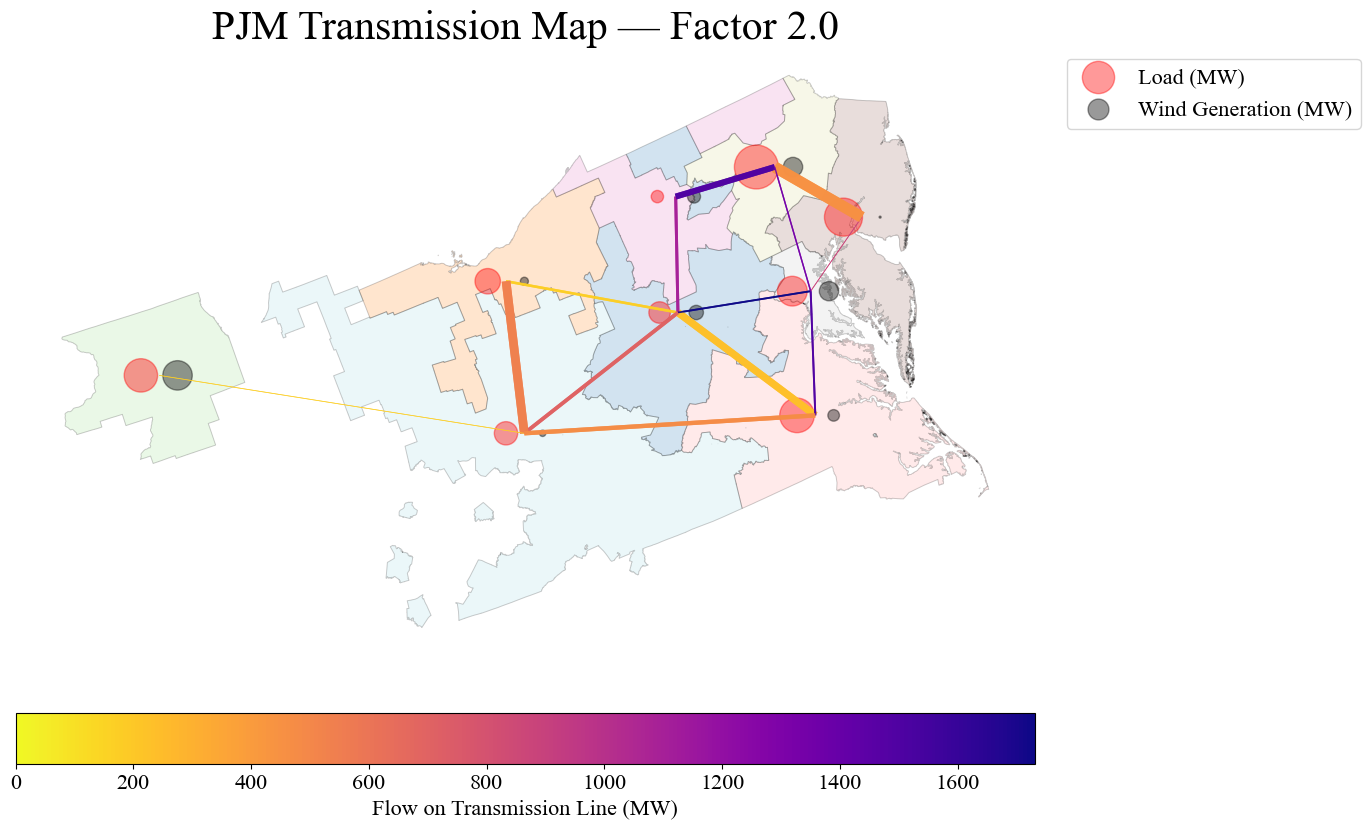

In [22]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------
# 1. READ THE SHAPEFILE
# ----------------------
# --------------------------------------------------------
# 1. LOAD DATA
# --------------------------------------------------------
shp_path = BASE_DIR / "data/inputs/ipm_v6_regions/IPM_Regions_201770405.shp"   # change this to your file
zones = gpd.read_file(shp_path)

# ----------------------
# 2. READ NETWORK LINES
# ----------------------


network_path = BASE_DIR / "data/inputs/Planned_Case/Network_modified.csv"
network = pd.read_csv(network_path)

zones_keep = [
    'PJM_AP', 'PJM_ATSI', 'PJM_COMD', 'PJM_Dom', 
    'PJM_EMAC', 'PJM_PENE', 'PJM_SMAC', 'PJM_WMAC', 'PJM_West'
]

# Inspect columns
print(zones.columns)
print(network.columns)

zones = zones[zones['IPM_Region'].isin(zones_keep)]

zones["centroid"] = zones.geometry.centroid

# Build a FAST lookup table
centroid_map = dict(zip(zones["IPM_Region"], zones["centroid"]))



loads = pd.read_csv(BASE_DIR / 'data/inputs/Planned_Case/load.csv')





# Optional: check zone names
network["Start_Zone"] = network["Start_Zone"].str.strip()
network["End_Zone"]   = network["End_Zone"].str.strip()


# -------------------------
# 3. BUILD ALL LINESTRINGS
# -------------------------
def make_line(start_zone, end_zone):
    if start_zone not in centroid_map or end_zone not in centroid_map:
        return None
    return LineString([centroid_map[start_zone], centroid_map[end_zone]])

network["geometry"] = network.apply(
    lambda row: make_line(row["Start_Zone"], row["End_Zone"]),
    axis=1
)

# Remove lines that failed
network = network[network["geometry"].notna()].copy()
network = gpd.GeoDataFrame(network, geometry="geometry", crs=zones.crs)


# --------------------------
# 4. SCALE LINE THICKNESS
# --------------------------
cap = pd.to_numeric(network["Line_Max_Flow_MW"], errors="coerce")

cap_min, cap_max = cap.min(), cap.max()
network["line_width"] = 0.5 + (cap - cap_min) / (cap_max - cap_min) * (8 - 0.5)



for factor in factors:
    gens  = pd.read_csv(BASE_DIR / f"data/inputs/Planned_Case/combined_generation_modified_{factor}_offshore.csv")            # columns: PJM_Zone, Total_Gen_2030
    flows = pd.read_csv(BASE_DIR / f"results/line_loads_factor_{factor}_offshore.csv")          # columns: line_id, flow_MW
    target_zones = ["PJM_Dom", "PJM_EMAC"]   
    gens['ZONE'] = gens['ZONE'].str.strip()
    gens = gens[gens['ZONE'].isin(zones_keep)]
    gens_wind= gens.loc[(gens['FUEL_TYPE']== 'WND'),'PMAX']
    # --------------------------------------------------------
    # 3. PREP FIGURE
    # --------------------------------------------------------
    fig, ax = plt.subplots(figsize=(14, 12))

    # --------------------------------------------------------
    # 4. PLOT ZONES IN BLACK & WHITE
    # --------------------------------------------------------
    zones.plot(
        ax=ax,
        column='IPM_Region',    # color by zone
        cmap='tab20',            # categorical colormap
        edgecolor='black',
        linewidth=0.7,
        legend=True,             # show zone names in legend
        alpha=0.2
    )
    global_max = np.max(flows["flow"].values)
    global_min = np.min(flows["flow"].values)


    # Attach flows (same row order)
    network["flow"] = flows["flow"].values

    # Lines colored by flow
    network.plot(
        ax=ax,
        column="flow",
        cmap="plasma_r",
        linewidth=network["line_width"],  # works now
        alpha=0.9,
        vmin = 0,
        vmax= global_max
    )

    # Colorbar
    sm = plt.cm.ScalarMappable(
        cmap="plasma_r",
        norm=plt.Normalize(vmin=0, vmax=global_max)
    )
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05)
    cbar.set_label("Flow on Transmission Line (MW)")



    zone_centroids = zones.geometry.centroid

    # Normalize sizes
    load_size = loads["Peak_Load_2030"].values
    gen_size  = gens_wind.values

    load_s = 1000 * (load_size / load_size.max())   # circle area scaling
    gen_s  = 10000 * (gen_size  / load_size.max())
    offset = 30000  
    load_x = zone_centroids.x - offset
    gen_x  = zone_centroids.x + offset
    # LOAD = red circles
    ax.scatter(
        load_x,
        zone_centroids.y,
        s=load_s,
        color="red",
        alpha=0.4,
        label="Load (MW)"
    )

    # GENERATION = blue circles
    ax.scatter(
        gen_x,
        zone_centroids.y,
        s=gen_s,
        color="black",
        alpha=0.4,
        label="Wind Generation (MW)"
    )

    # --------------------------------------------------------
    # 8. LEGEND OUTSIDE
    # --------------------------------------------------------
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=True
    )

    # --------------------------------------------------------
    # 9. FINISH
    # --------------------------------------------------------
    ax.set_title(f"PJM Transmission Map — Factor {factor}", fontsize=30)
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()


